# AC FEUP 21/22

## Main dependencies

In [366]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
import numpy as np
import sklearn

# use to not cut columns
pd.set_option('max_columns', None)

# njobs to use in sklearn models
configNJobs = -1

## Import data

### Training data

In [367]:
# import data
def read_csv(file, dtype={}, na_values=None):
    return pd.read_csv("data/" + file, sep=";", dtype=dtype, na_values=na_values)

account_df = read_csv("account.csv")
card_df = read_csv("card_train.csv")
client_df = read_csv("client.csv")
disp_df = read_csv("disp.csv")
district_df = read_csv("district.csv", na_values="?")
loan_df = read_csv("loan_train.csv")
trans_df = read_csv("trans_train.csv", dtype={'bank': 'str'})

trans_df.head()

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
0,1548749,5270,930113,credit,credit in cash,800.0,800.0,NaN,NaN,NaN
1,1548750,5270,930114,credit,collection from another bank,44749.0,45549.0,NaN,IJ,80269753.0
2,3393738,11265,930114,credit,credit in cash,1000.0,1000.0,NaN,NaN,NaN
3,3122924,10364,930117,credit,credit in cash,1100.0,1100.0,NaN,NaN,NaN
4,1121963,3834,930119,credit,credit in cash,700.0,700.0,NaN,NaN,NaN


In [368]:
# clean column names (some columns come with an extra whitespace)
district_df.rename(columns=lambda x: x.strip(), inplace=True)

# rename some columns for easier interaction
district_df.rename(columns={"no. of inhabitants": "people_count",
                            "no. of municipalities with inhabitants < 499": "muni_499_count",
                            "no. of municipalities with inhabitants 500-1999": "muni_500-1999_count",
                            "no. of municipalities with inhabitants 2000-9999": "muni_2000-9999_count",
                            "no. of municipalities with inhabitants >10000": "muni_10000_count",
                            "no. of cities": "cities_count",
                            "ratio of urban inhabitants": "ratio_urban_people",
                            "average salary": "avg_salary",
                            "unemploymant rate '95": "unemp_rate_95",
                            "unemploymant rate '96": "unemp_rate_96",
                            "no. of enterpreneurs per 1000 inhabitants": "enterp_per1000",
                            "no. of commited crimes '95": "crime_count_95",
                            "no. of commited crimes '96": "crime_count_96"},
                   inplace=True)
district_df.head()

,code,name,region,people_count,muni_499_count,muni_500-1999_count,muni_2000-9999_count,muni_10000_count,cities_count,ratio_urban_people,avg_salary,unemp_rate_95,unemp_rate_96,enterp_per1000,crime_count_95,crime_count_96
0,1,Hl.m. Praha,Prague,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167,85677.0,99107
1,2,Benesov,central Bohemia,88884,80,26,6,2,5,46.7,8507,1.67,1.85,132,2159.0,2674
2,3,Beroun,central Bohemia,75232,55,26,4,1,5,41.7,8980,1.95,2.21,111,2824.0,2813
3,4,Kladno,central Bohemia,149893,63,29,6,2,6,67.4,9753,4.64,5.05,109,5244.0,5892
4,5,Kolin,central Bohemia,95616,65,30,4,1,6,51.4,9307,3.85,4.43,118,2616.0,3040


### Test data

In [369]:
card_test_df = read_csv("card_test.csv")
loan_test_df = read_csv("loan_test.csv")
trans_test_df = read_csv("trans_test.csv", dtype={'bank': 'str'})

## Domain analysis

<AxesSubplot:xlabel='status', ylabel='count'>

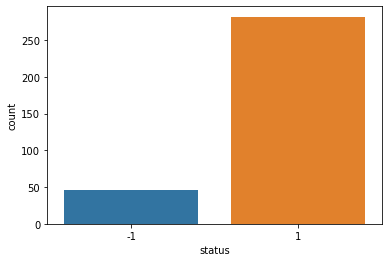

In [370]:
sb.countplot(x="status", data=loan_df)

In [371]:
len(loan_df[loan_df["status"] == 1]) / len(loan_df)

0.8597560975609756

Almost **90%** of the loans in the dataset have been granted (positive result). This means that accuracy isn't a good metric to optimize for.

In [372]:
print("Client count: ", len(client_df))
print("Card count: ", len(card_df))

Client count:  5369
Card count:  177


Since the dataset is somewhat old (1990), most clients don't have a credit card.

## Dealing with missing values

### Account data

In [373]:
account_df.isnull().sum()

account_id     0
district_id    0
frequency      0
date           0
dtype: int64

No NULL data to deal with on this dataframe.

### Card data

In [374]:
card_df.isnull().sum()

card_id    0
disp_id    0
type       0
issued     0
dtype: int64

No NULL data to deal with on this dataframe.

In [375]:
card_test_df.isnull().sum()

card_id    0
disp_id    0
type       0
issued     0
dtype: int64

### Client data

In [376]:
client_df.isnull().sum()

client_id       0
birth_number    0
district_id     0
dtype: int64

There are no NULL values on this dataset to deal with.

### Disposition data

In [377]:
disp_df.isnull().sum()

disp_id       0
client_id     0
account_id    0
type          0
dtype: int64

No NULL data to deal with on this dataframe.

### District data

In [378]:
district_df.isnull().sum()

code                    0
name                    0
region                  0
people_count            0
muni_499_count          0
muni_500-1999_count     0
muni_2000-9999_count    0
muni_10000_count        0
cities_count            0
ratio_urban_people      0
avg_salary              0
unemp_rate_95           1
unemp_rate_96           0
enterp_per1000          0
crime_count_95          1
crime_count_96          0
dtype: int64

There is 1 NULL value in _unemploymant rate '95_ and _no. of commited crimes '95_.

In [379]:
district_df[district_df["unemp_rate_95"].isnull()]

,code,name,region,people_count,muni_499_count,muni_500-1999_count,muni_2000-9999_count,muni_10000_count,cities_count,ratio_urban_people,avg_salary,unemp_rate_95,unemp_rate_96,enterp_per1000,crime_count_95,crime_count_96
68,69,Jesenik,north Moravia,42821,4,13,5,1,3,48.4,8173,NaN,7.01,124,NaN,1358


Both of these missing value are for the district of _Jesenik_. We can find the mean growth/shrinkage of the unemploymant and number of crimes commit from 1995 to 1996, and use that to fill the missing values of 1995 for this district.

In [380]:
unem_rate_95 = district_df[district_df["unemp_rate_95"].notnull()]["unemp_rate_95"]
unem_rate_96 = district_df[district_df["unemp_rate_96"].notnull()]["unemp_rate_96"]

unem_growth_series = unem_rate_95 / unem_rate_96
unem_growth = unem_growth_series.sum() / unem_growth_series.count()

district_df["unemp_rate_95"] = district_df.apply(lambda x: x["unemp_rate_96"] * unem_growth if np.isnan(x["unemp_rate_95"]) else x["unemp_rate_95"], axis=1)

In [381]:
no_crime_95 = district_df[district_df["crime_count_95"].notnull()]["crime_count_95"]
no_crime_96 = district_df[district_df["crime_count_96"].notnull()]["crime_count_96"]

crime_growth_series = no_crime_95 / no_crime_96
crime_growth = crime_growth_series.sum() / crime_growth_series.count()

district_df["crime_count_95"] = district_df.apply(lambda x: x["crime_count_96"] * crime_growth if np.isnan(x["crime_count_95"]) else x["crime_count_95"], axis=1)

In [382]:
district_df[district_df["code"] == 69]

,code,name,region,people_count,muni_499_count,muni_500-1999_count,muni_2000-9999_count,muni_10000_count,cities_count,ratio_urban_people,avg_salary,unemp_rate_95,unemp_rate_96,enterp_per1000,crime_count_95,crime_count_96
68,69,Jesenik,north Moravia,42821,4,13,5,1,3,48.4,8173,5.759683,7.01,124,1321.520511,1358


The missing values have been taken care of.

### Loan data

In [383]:
loan_df.isnull().sum()

loan_id       0
account_id    0
date          0
amount        0
duration      0
payments      0
status        0
dtype: int64

There are no NULL values to fill on this dataframe.

In [384]:
loan_test_df.isnull().sum()

loan_id         0
account_id      0
date            0
amount          0
duration        0
payments        0
status        354
dtype: int64

These missing values (_status_) don't matter as they are the targets of our prediction model.

### Transaction data

In [385]:
trans_df.isnull().sum()

trans_id           0
account_id         0
date               0
type               0
operation      70761
amount             0
balance            0
k_symbol      185244
bank          299443
account       294456
dtype: int64

In [386]:
trans_test_df.isnull().sum()

trans_id          0
account_id        0
date              0
type              0
operation      5130
amount            0
balance           0
k_symbol      17419
bank          24377
account       21061
dtype: int64

There are 4 attributes with a large quantity of null values on this dataframe that have to dealt with: _operation_, _k\_symbol_, _bank_, and _account_.

In [387]:
trans_df['operation'].value_counts()

withdrawal in cash              165270
remittance to another bank       70737
credit in cash                   62202
collection from another bank     26505
credit card withdrawal            1210
Name: operation, dtype: int64

In [388]:
len(trans_df[trans_df['operation'].isnull()]) / len(trans_df['operation']) * 100.0

17.838083113805663

The _operation_ attribute is categorical and doesn't reveal an inherited order. It can be enconded with 3 attributes using binary encoding.

This attribute is problematic because it contains a significant number of NULL values ($17.8\%$).

It was decided that these rows will be filled with _unkown_.

In [389]:
trans_df['operation'].fillna('unknown', inplace=True)

trans_test_df['operation'].fillna('unknown', inplace=True)

In [390]:
trans_df['k_symbol'].value_counts()

interest credited                        70761
payment for statement                    58377
household                                42839
                                         19065
old-age pension                          13502
insurrance payment                        6592
sanction interest if negative balance      305
Name: k_symbol, dtype: int64

There is a category that is an empty string. It is likelly that the missing values were intended to be part of this category aswell. It is assumed that these rows with the _empty_ category refer to common transactions that aren't related to pensions, insurrance, etc... The missing values and the empty rows of this attribute will be renamed to _no_symbol_.

In [391]:
def treat_null_k_symbol(row):
    k_symb = row['k_symbol']
    if isinstance(k_symb, float):
        return 'no_symbol'
    elif k_symb == " ":
        return 'no_symbol'
    else:
        return k_symb
    

trans_df['k_symbol'] = trans_df.apply(treat_null_k_symbol, axis=1)
trans_test_df['k_symbol'] = trans_test_df.apply(treat_null_k_symbol, axis=1)

trans_df['k_symbol'].value_counts()

no_symbol                                204309
interest credited                         70761
payment for statement                     58377
household                                 42839
old-age pension                           13502
insurrance payment                         6592
sanction interest if negative balance       305
Name: k_symbol, dtype: int64

There many rows where we don't know which is the bank of the partner.

In [392]:
trans_df['bank'].value_counts()

ST    8114
GH    7886
EF    7878
AB    7666
UV    7618
OP    7595
IJ    7536
YZ    7471
QR    7413
KL    7397
WX    7033
CD    7009
MN    6626
Name: bank, dtype: int64

In [393]:
trans_df['account'].value_counts()

0.0           4987
15916598.0      48
62457513.0      48
6149286.0       48
42988401.0      48
              ... 
99218499.0       1
54261672.0       1
28306174.0       1
91523855.0       1
53761804.0       1
Name: account, Length: 4536, dtype: int64

The unknown information about the partner's bank tranlates to unkown information about the partner. This is sometimes represented by a **0** on the _account_ attribute.

In [394]:
print("Number of unknown banks:", len(trans_df[trans_df['bank'].isnull()]))
print("Number of unknown partners:", len(trans_df[trans_df['account'].isnull()]) + len(trans_df[trans_df['account'] == 0]))

Number of unknown banks: 299443
Number of unknown partners: 299443


The number of unknown banks is the same as the number of unkown partners => these 2 features are highly correlated. Even though these 2 attributes aren't likelly to contribute anything to our dataset, we can create an **'unknown' bank** and set all unkown _account_ attributes to 0.

In [395]:
trans_df['account'].fillna(0, inplace=True)
trans_df['bank'].fillna("unknown", inplace=True)

trans_test_df['account'].fillna(0, inplace=True)
trans_test_df['bank'].fillna("unknown", inplace=True)

trans_df.head()

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
0,1548749,5270,930113,credit,credit in cash,800.0,800.0,no_symbol,unknown,0.0
1,1548750,5270,930114,credit,collection from another bank,44749.0,45549.0,no_symbol,IJ,80269753.0
2,3393738,11265,930114,credit,credit in cash,1000.0,1000.0,no_symbol,unknown,0.0
3,3122924,10364,930117,credit,credit in cash,1100.0,1100.0,no_symbol,unknown,0.0
4,1121963,3834,930119,credit,credit in cash,700.0,700.0,no_symbol,unknown,0.0


## Join data

It is needed to join all datasets into a **single one**.

In [396]:
def join(df1, df2, key1, key2, suff, t="inner"):
    return df1.merge(df2, left_on=key1, right_on=key2, how=t, suffixes=suff)

### Join account with disposition

All _Accounts_ have at least one _Disposition_. There are more _Dispositions_ than _Accounts_, because some clients are **owners** of an account while others are **disponent owners**.

In [397]:
disp_df["type"].value_counts()

OWNER        4500
DISPONENT     869
Name: type, dtype: int64

In order to join all data later, we will create an attribute on the _Account_ table that reflects whether the account is co-owned. Note that the _DISPONENTs_ will be dropped from the joined table. The type attribute can be dropped as well all dispositions are _OWNER_.

In [398]:
def join_acc_disp():
    acc_disp = join(account_df, disp_df, "account_id", "account_id", ['', '_disp'])
    acc_disp.rename(columns={"type": "account_type",
                             "date": "account_creation",
                             "frequency": "issuance_freq"}, inplace=True)
    # count groups
    owner_count = acc_disp["account_id"].value_counts()
    acc_disp["is_coowned"] = acc_disp.apply(lambda row: True if owner_count[row["account_id"]] > 1 else False, axis=1)
    # cleanup
    acc_disp.drop(acc_disp[acc_disp["account_type"] == "DISPONENT"].index, inplace=True)
    acc_disp.drop(["account_type"], axis=1, inplace=True)
    #
    return acc_disp

df = join_acc_disp()
df

,account_id,district_id,issuance_freq,account_creation,disp_id,client_id,is_coowned
0,576,55,monthly issuance,930101,692,692,True
2,3818,74,monthly issuance,930101,4601,4601,True
4,704,55,monthly issuance,930101,844,844,True
6,2378,16,monthly issuance,930101,2873,2873,False
7,2632,24,monthly issuance,930102,3177,3177,False
...,...,...,...,...,...,...,...
5362,124,55,monthly issuance,971228,149,149,False
5363,3958,59,monthly issuance,971228,4774,4774,True
5365,777,30,monthly issuance,971228,929,929,False
5366,1573,63,monthly issuance,971229,1906,1906,False


### Join clients

Nothing special needs to be done to join the _Client_ table. We can drop the some attributes (foreign keys).

In [399]:
df = join(df, client_df, 'client_id', 'client_id', ['', '_client'], t="left")
df.rename(columns={"age": "client_age"}, inplace=True)
df.drop(['client_id'], axis=1, inplace=True)
df

,account_id,district_id,issuance_freq,account_creation,disp_id,is_coowned,birth_number,district_id_client
0,576,55,monthly issuance,930101,692,True,365111,74
1,3818,74,monthly issuance,930101,4601,True,350402,1
2,704,55,monthly issuance,930101,844,True,450114,22
3,2378,16,monthly issuance,930101,2873,False,755324,16
4,2632,24,monthly issuance,930102,3177,False,380812,24
...,...,...,...,...,...,...,...,...
4495,124,55,monthly issuance,971228,149,False,480627,55
4496,3958,59,monthly issuance,971228,4774,True,510814,59
4497,777,30,monthly issuance,971228,929,False,350423,30
4498,1573,63,monthly issuance,971229,1906,False,220707,63


### Join district

Both the _Account_ and the _Client_ table have a foreign key to the _District_ table.

Only the _Client_ key will be joined with the _District_ table, because we only care about the account owner's residence and now the place where the account was registered.

In [400]:
df = join(df, district_df, 'district_id_client', 'code', ['', '_district'])
df.rename(columns={"code": "district_code", "name": "district_name"}, inplace=True)
df.drop(['district_id', 'district_id_client'], axis=1, inplace=True)
df

,account_id,issuance_freq,account_creation,disp_id,is_coowned,birth_number,district_code,district_name,region,people_count,muni_499_count,muni_500-1999_count,muni_2000-9999_count,muni_10000_count,cities_count,ratio_urban_people,avg_salary,unemp_rate_95,unemp_rate_96,enterp_per1000,crime_count_95,crime_count_96
0,576,monthly issuance,930101,692,True,365111,74,Ostrava - mesto,north Moravia,323870,0,0,0,1,1,100.0,10673,4.75,5.44,100,18782.0,18347
1,2484,monthly issuance,930103,2999,False,795324,74,Ostrava - mesto,north Moravia,323870,0,0,0,1,1,100.0,10673,4.75,5.44,100,18782.0,18347
2,1338,monthly issuance,930111,1619,True,425127,74,Ostrava - mesto,north Moravia,323870,0,0,0,1,1,100.0,10673,4.75,5.44,100,18782.0,18347
3,1179,monthly issuance,930123,1419,True,185125,74,Ostrava - mesto,north Moravia,323870,0,0,0,1,1,100.0,10673,4.75,5.44,100,18782.0,18347
4,1649,monthly issuance,930126,1999,False,825210,74,Ostrava - mesto,north Moravia,323870,0,0,0,1,1,100.0,10673,4.75,5.44,100,18782.0,18347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,1976,monthly issuance,970325,2401,False,485126,26,Plzen - mesto,west Bohemia,170449,0,0,0,1,1,100.0,10787,2.64,3.09,131,6041.0,6261
4496,3176,monthly issuance,970326,3841,False,190708,26,Plzen - mesto,west Bohemia,170449,0,0,0,1,1,100.0,10787,2.64,3.09,131,6041.0,6261
4497,768,monthly issuance,970703,918,False,641223,26,Plzen - mesto,west Bohemia,170449,0,0,0,1,1,100.0,10787,2.64,3.09,131,6041.0,6261
4498,307,monthly issuance,970807,374,False,670614,26,Plzen - mesto,west Bohemia,170449,0,0,0,1,1,100.0,10787,2.64,3.09,131,6041.0,6261


### Create test DataFrame

The next 3 tables have train and test versions (train/test split). As such, we'll work with 2 DataFrames from now on: _df_ and _df\_test_.

In [401]:
df_test = df.copy()

### Join loan

In [402]:
def join_loan(df, loan_df):
    ret = join(df, loan_df, 'account_id', 'account_id', ['', '_loan'], t="right")
    ret.drop(['loan_id'], axis=1, inplace=True)
    ret.rename(columns={"date": "loan_date"}, inplace=True)
    return ret

df = join_loan(df, loan_df)
df_test = join_loan(df_test, loan_test_df)
df

,account_id,issuance_freq,account_creation,disp_id,is_coowned,birth_number,district_code,district_name,region,people_count,muni_499_count,muni_500-1999_count,muni_2000-9999_count,muni_10000_count,cities_count,ratio_urban_people,avg_salary,unemp_rate_95,unemp_rate_96,enterp_per1000,crime_count_95,crime_count_96,loan_date,amount,duration,payments,status
0,1787,weekly issuance,930322,2166,False,475722,30,Sokolov,west Bohemia,94812,15,13,8,2,10,81.8,9650,3.38,3.67,100,2985.0,2804,930705,96396,12,8033,-1
1,1801,monthly issuance,930213,2181,False,680722,46,Nachod,east Bohemia,112709,48,20,7,3,10,73.5,8369,1.79,2.31,117,2854.0,2618,930711,165960,36,4610,1
2,9188,monthly issuance,930208,11006,False,360602,45,Jicin,east Bohemia,77917,85,19,6,1,5,53.5,8390,2.28,2.89,132,2080.0,2122,930728,127080,60,2118,1
3,1843,monthly issuance,930130,2235,False,405420,14,Ceske Budejovice,south Bohemia,177686,69,27,10,1,9,74.8,10045,1.42,1.71,135,6604.0,6295,930803,105804,36,2939,1
4,11013,weekly issuance,930214,13231,False,780907,63,Vyskov,south Moravia,86513,38,36,5,1,5,50.5,8288,3.79,4.52,110,1562.0,1460,930906,274740,60,4579,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,9030,monthly issuance,950121,10813,True,715410,72,Olomouc,north Moravia,226122,32,50,7,4,4,62.6,8994,3.80,4.79,110,9672.0,9208,961212,155616,48,3242,1
324,3189,monthly issuance,951129,3855,False,390320,29,Rokycany,west Bohemia,45714,52,10,5,1,6,55.6,8843,2.82,3.60,113,818.0,888,961215,222180,60,3703,-1
325,8972,monthly issuance,960521,10742,False,575504,70,Karvina,north Moravia,285387,0,2,8,5,7,89.9,10177,6.63,7.75,81,9878.0,10108,961221,45024,48,938,1
326,10963,monthly issuance,950520,13172,False,530601,16,Jindrichuv Hradec,south Bohemia,93931,74,21,10,1,8,56.9,8427,1.12,1.54,107,1874.0,1913,961225,115812,36,3217,1


### Join card

Almost no client in the dataset has a card. This proves to be problematic when joining the data as it creates many missing values or makes us lose information.

The _Card_ table contains only 2 useful informations: the type of the card (which can be ordered from 'worst' to 'best'), and the date of issuance. The type of the card helps us rank clients: a client with a gold card is better than a client with a junior card. The issuance date allows us to consider only cards that have been issued before the loan (only information before the issuance of a loan matters for its decision).

This **type** is categorical data. _junior_ accounts are for underarge people (lowest tier) and usually it isn't possible to withdrawl money from them, and _gold_ account are the highest tier. There is an implicit order here: _junior_ < _classic_ < _gold_.

In [403]:
card_disp = join(card_df, disp_df, 'disp_id', 'disp_id', ['_card', '_disp'])
cardtypes_df = card_disp.groupby([card_disp.account_id, card_disp.type_card]).size().unstack(fill_value=0)
cardtypes_df

type_card,classic,gold,junior
account_id,,,
33,0,1,0
43,0,0,1
66,1,0,0
71,0,0,1
73,1,0,0
...,...,...,...
10227,1,0,0
10411,0,1,0
10520,0,1,0


In [404]:
def join_cards(df, card_df):
    card_disp = join(card_df, disp_df, 'disp_id', 'disp_id', ['_card', '_disp'])
    cardtypes_df = card_disp.groupby(card_disp.account_id)['type_card'].value_counts().unstack(fill_value=0)
    #
    ret = join(df, cardtypes_df, 'account_id', 'account_id', ['', ''], t='left')
    ret.fillna(0, inplace=True)
    ret["cards"] = (ret["junior"] * 1 + ret["classic"] * 2 + ret["gold"] * 3).astype(int)
    ret.drop(["junior", "classic", "gold"], axis=1, inplace=True)
    # unneed now
    ret.drop(["disp_id"], axis=1, inplace=True)
    return ret

df = join_cards(df, card_df)
df_test = join_cards(df_test, card_df)
df

,account_id,issuance_freq,account_creation,is_coowned,birth_number,district_code,district_name,region,people_count,muni_499_count,muni_500-1999_count,muni_2000-9999_count,muni_10000_count,cities_count,ratio_urban_people,avg_salary,unemp_rate_95,unemp_rate_96,enterp_per1000,crime_count_95,crime_count_96,loan_date,amount,duration,payments,status,cards
0,1787,weekly issuance,930322,False,475722,30,Sokolov,west Bohemia,94812,15,13,8,2,10,81.8,9650,3.38,3.67,100,2985.0,2804,930705,96396,12,8033,-1,0
1,1801,monthly issuance,930213,False,680722,46,Nachod,east Bohemia,112709,48,20,7,3,10,73.5,8369,1.79,2.31,117,2854.0,2618,930711,165960,36,4610,1,0
2,9188,monthly issuance,930208,False,360602,45,Jicin,east Bohemia,77917,85,19,6,1,5,53.5,8390,2.28,2.89,132,2080.0,2122,930728,127080,60,2118,1,0
3,1843,monthly issuance,930130,False,405420,14,Ceske Budejovice,south Bohemia,177686,69,27,10,1,9,74.8,10045,1.42,1.71,135,6604.0,6295,930803,105804,36,2939,1,0
4,11013,weekly issuance,930214,False,780907,63,Vyskov,south Moravia,86513,38,36,5,1,5,50.5,8288,3.79,4.52,110,1562.0,1460,930906,274740,60,4579,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,9030,monthly issuance,950121,True,715410,72,Olomouc,north Moravia,226122,32,50,7,4,4,62.6,8994,3.80,4.79,110,9672.0,9208,961212,155616,48,3242,1,0
324,3189,monthly issuance,951129,False,390320,29,Rokycany,west Bohemia,45714,52,10,5,1,6,55.6,8843,2.82,3.60,113,818.0,888,961215,222180,60,3703,-1,0
325,8972,monthly issuance,960521,False,575504,70,Karvina,north Moravia,285387,0,2,8,5,7,89.9,10177,6.63,7.75,81,9878.0,10108,961221,45024,48,938,1,0
326,10963,monthly issuance,950520,False,530601,16,Jindrichuv Hradec,south Bohemia,93931,74,21,10,1,8,56.9,8427,1.12,1.54,107,1874.0,1913,961225,115812,36,3217,1,0


In [405]:
def join_cards(df, card_df):
    card_disp = join(card_df, disp_df, 'disp_id', 'disp_id', ['_card', '_disp'])
    cardtypes_df = card_disp.groupby(card_disp.account_id)['type_card'].value_counts().unstack(fill_value=0)
    #
    ret = join(df, cardtypes_df, 'account_id', 'account_id', ['', ''], t='left')
    ret.fillna(0, inplace=True)
    ret["cards"] = (ret["junior"] * 1 + ret["classic"] * 2 + ret["gold"] * 3).astype(int)
    ret.drop(["junior", "classic", "gold"], axis=1, inplace=True)
    return ret

df = join_cards(df, card_df)
df_test = join_cards(df_test, card_df)
df

,account_id,issuance_freq,account_creation,is_coowned,birth_number,district_code,district_name,region,people_count,muni_499_count,muni_500-1999_count,muni_2000-9999_count,muni_10000_count,cities_count,ratio_urban_people,avg_salary,unemp_rate_95,unemp_rate_96,enterp_per1000,crime_count_95,crime_count_96,loan_date,amount,duration,payments,status,cards
0,1787,weekly issuance,930322,False,475722,30,Sokolov,west Bohemia,94812,15,13,8,2,10,81.8,9650,3.38,3.67,100,2985.0,2804,930705,96396,12,8033,-1,0
1,1801,monthly issuance,930213,False,680722,46,Nachod,east Bohemia,112709,48,20,7,3,10,73.5,8369,1.79,2.31,117,2854.0,2618,930711,165960,36,4610,1,0
2,9188,monthly issuance,930208,False,360602,45,Jicin,east Bohemia,77917,85,19,6,1,5,53.5,8390,2.28,2.89,132,2080.0,2122,930728,127080,60,2118,1,0
3,1843,monthly issuance,930130,False,405420,14,Ceske Budejovice,south Bohemia,177686,69,27,10,1,9,74.8,10045,1.42,1.71,135,6604.0,6295,930803,105804,36,2939,1,0
4,11013,weekly issuance,930214,False,780907,63,Vyskov,south Moravia,86513,38,36,5,1,5,50.5,8288,3.79,4.52,110,1562.0,1460,930906,274740,60,4579,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,9030,monthly issuance,950121,True,715410,72,Olomouc,north Moravia,226122,32,50,7,4,4,62.6,8994,3.80,4.79,110,9672.0,9208,961212,155616,48,3242,1,0
324,3189,monthly issuance,951129,False,390320,29,Rokycany,west Bohemia,45714,52,10,5,1,6,55.6,8843,2.82,3.60,113,818.0,888,961215,222180,60,3703,-1,0
325,8972,monthly issuance,960521,False,575504,70,Karvina,north Moravia,285387,0,2,8,5,7,89.9,10177,6.63,7.75,81,9878.0,10108,961221,45024,48,938,1,0
326,10963,monthly issuance,950520,False,530601,16,Jindrichuv Hradec,south Bohemia,93931,74,21,10,1,8,56.9,8427,1.12,1.54,107,1874.0,1913,961225,115812,36,3217,1,0


In [406]:
def join_cards(df, card_df):
    card_disp = join(card_df, disp_df, 'disp_id', 'disp_id', ['_card', '_disp'])
    cardtypes_df = card_disp.groupby(card_disp.account_id)['type_card'].value_counts().unstack(fill_value=0)
    #
    ret = join(df, cardtypes_df, 'account_id', 'account_id', ['', ''], t='left')
    ret.fillna(0, inplace=True)
    ret["cards"] = (ret["junior"] * 1 + ret["classic"] * 2 + ret["gold"] * 3).astype(int)
    ret.drop(["junior", "classic", "gold"], axis=1, inplace=True)
    return ret

df = join_cards(df, card_df)
df_test = join_cards(df_test, card_df)
df

,account_id,issuance_freq,account_creation,is_coowned,birth_number,district_code,district_name,region,people_count,muni_499_count,muni_500-1999_count,muni_2000-9999_count,muni_10000_count,cities_count,ratio_urban_people,avg_salary,unemp_rate_95,unemp_rate_96,enterp_per1000,crime_count_95,crime_count_96,loan_date,amount,duration,payments,status,cards
0,1787,weekly issuance,930322,False,475722,30,Sokolov,west Bohemia,94812,15,13,8,2,10,81.8,9650,3.38,3.67,100,2985.0,2804,930705,96396,12,8033,-1,0
1,1801,monthly issuance,930213,False,680722,46,Nachod,east Bohemia,112709,48,20,7,3,10,73.5,8369,1.79,2.31,117,2854.0,2618,930711,165960,36,4610,1,0
2,9188,monthly issuance,930208,False,360602,45,Jicin,east Bohemia,77917,85,19,6,1,5,53.5,8390,2.28,2.89,132,2080.0,2122,930728,127080,60,2118,1,0
3,1843,monthly issuance,930130,False,405420,14,Ceske Budejovice,south Bohemia,177686,69,27,10,1,9,74.8,10045,1.42,1.71,135,6604.0,6295,930803,105804,36,2939,1,0
4,11013,weekly issuance,930214,False,780907,63,Vyskov,south Moravia,86513,38,36,5,1,5,50.5,8288,3.79,4.52,110,1562.0,1460,930906,274740,60,4579,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,9030,monthly issuance,950121,True,715410,72,Olomouc,north Moravia,226122,32,50,7,4,4,62.6,8994,3.80,4.79,110,9672.0,9208,961212,155616,48,3242,1,0
324,3189,monthly issuance,951129,False,390320,29,Rokycany,west Bohemia,45714,52,10,5,1,6,55.6,8843,2.82,3.60,113,818.0,888,961215,222180,60,3703,-1,0
325,8972,monthly issuance,960521,False,575504,70,Karvina,north Moravia,285387,0,2,8,5,7,89.9,10177,6.63,7.75,81,9878.0,10108,961221,45024,48,938,1,0
326,10963,monthly issuance,950520,False,530601,16,Jindrichuv Hradec,south Bohemia,93931,74,21,10,1,8,56.9,8427,1.12,1.54,107,1874.0,1913,961225,115812,36,3217,1,0


In [407]:
df["cards"].value_counts()

0    317
2      8
3      2
1      1
Name: cards, dtype: int64

There are very few clients with cards. Every client with a card has been granted a loan.

In [408]:
df[df["cards"] > 0]["status"].value_counts()

1    11
Name: status, dtype: int64

### Join transactions

The _Transaction_ table poses a problem: there are many transactions for each account. If we just join this table, we'll get multiple rows for each loan which is undesirable.

We have to find a way to extract the useful information from this table to merge it into the dataset.

In [409]:
def filter_acc_ids(df, trans_df):
    tdf = trans_df.copy()
    
    loan_accs = set(df["account_id"])
    tr_to_drop = []
    for id, row in tdf.iterrows():
        if row["account_id"] not in loan_accs:
            tr_to_drop.append(id)

    tdf.drop(tr_to_drop, inplace=True)
    return tdf

tdf = filter_acc_ids(df, trans_df)
tdf_test = filter_acc_ids(df_test, trans_test_df)
tdf.shape

(24494, 10)

**Filter by date**: only consider transactions that happened before the loan decision.

In [410]:
def filter_by_date(df, tdf):
    tr_to_drop = []
    for id, row in tdf.iterrows():
        tr_date = row["date"]
        acc_id = row["account_id"]
        for _, loan_row in df[df["account_id"] == acc_id].iterrows():
            loan_date = loan_row["loan_date"]
            if loan_date < tr_date:
                tr_to_drop.append(id)

    tdf.drop(tr_to_drop, inplace=True)
    return tdf

tdf = filter_by_date(df, tdf)
tdf_test = filter_by_date(df_test, tdf_test)
tdf.shape

(24494, 10)

All transactions happened before the loan decision, so none were dropped.

**Apply transaction types to the transaction amount**: withdrawls imply a negative balance change on the account's funds.

In [411]:
def convert_amount(tdf):
    def convert_amount_inner(row):
        ammount = abs(row['amount'])
        # else are withdrawls
        return ammount if row['type'] == "credit" else -ammount

    # convert ammount to negative according to transaction type
    tdf['amount'] = tdf.apply(convert_amount_inner, axis=1)
    return tdf

tdf = convert_amount(tdf)
tdf_test = convert_amount(tdf_test)
tdf

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
0,1548749,5270,930113,credit,credit in cash,800.0,800.0,no_symbol,unknown,0.0
1,1548750,5270,930114,credit,collection from another bank,44749.0,45549.0,no_symbol,IJ,80269753.0
2,3393738,11265,930114,credit,credit in cash,1000.0,1000.0,no_symbol,unknown,0.0
3,3122924,10364,930117,credit,credit in cash,1100.0,1100.0,no_symbol,unknown,0.0
4,1121963,3834,930119,credit,credit in cash,700.0,700.0,no_symbol,unknown,0.0
...,...,...,...,...,...,...,...,...,...,...
24489,934562,3189,961210,withdrawal,withdrawal in cash,-6900.0,59578.8,no_symbol,unknown,0.0
24490,2729876,9030,961211,withdrawal,withdrawal in cash,-14600.0,60694.1,no_symbol,unknown,0.0
24491,2712272,8972,961213,withdrawal,remittance to another bank,-4719.0,56184.3,household,EF,61556398.0
24492,2712433,8972,961217,withdrawal,withdrawal in cash,-17800.0,38384.3,no_symbol,unknown,0.0


**Target bank and account**: as was mentioned in the _Dealing with missing values_ section, most transactions are sent to an unknown bank/account (83%). It was decided that no useful information could be extracted from these 2 columns to create an attribute for the joined dataset.

In [412]:
tdf[tdf["bank"] == "unknown"]["bank"].count() / tdf["bank"].count()

0.8296725728749897

In [413]:
tdf.drop(["bank", "account"], axis=1, inplace=True)
tdf_test.drop(["bank", "account"], axis=1, inplace=True)
tdf

,trans_id,account_id,date,type,operation,amount,balance,k_symbol
0,1548749,5270,930113,credit,credit in cash,800.0,800.0,no_symbol
1,1548750,5270,930114,credit,collection from another bank,44749.0,45549.0,no_symbol
2,3393738,11265,930114,credit,credit in cash,1000.0,1000.0,no_symbol
3,3122924,10364,930117,credit,credit in cash,1100.0,1100.0,no_symbol
4,1121963,3834,930119,credit,credit in cash,700.0,700.0,no_symbol
...,...,...,...,...,...,...,...,...
24489,934562,3189,961210,withdrawal,withdrawal in cash,-6900.0,59578.8,no_symbol
24490,2729876,9030,961211,withdrawal,withdrawal in cash,-14600.0,60694.1,no_symbol
24491,2712272,8972,961213,withdrawal,remittance to another bank,-4719.0,56184.3,household
24492,2712433,8972,961217,withdrawal,withdrawal in cash,-17800.0,38384.3,no_symbol


**Number of times the user was sanctioned for negative balance**: knowing which users had to pay sanctions for reaching negative balances might prove useful to know which loans to reject.

In [414]:
def sanction_count(df, tdf):
    grouped = tdf.groupby("account_id")

    sanction_df = pd.DataFrame(columns=["account_id", "sanctions"])
    for acc_id, group in grouped:
        sanc_cnt = group[group["k_symbol"] == "sanction interest if negative balance"]["k_symbol"].count()
        sanction_df = sanction_df.append({"account_id": acc_id, "sanctions": sanc_cnt}, ignore_index=True)

    df["sanctions"] = sanction_df["sanctions"]
    df["sanctions"].fillna(0.0, inplace=True)
    return df

df = sanction_count(df, tdf)
df_test = sanction_count(df_test, tdf_test)
df["sanctions"].value_counts()

0    314
1      5
2      3
6      2
3      2
4      1
5      1
Name: sanctions, dtype: int64

**Mean household payments**: knowing how much a client pays for its household might prove useful to know how tight for money they are.

In [415]:
def household_mean(df, tdf):
    grouped = tdf.groupby("account_id")

    household_df = pd.DataFrame(columns=["account_id", "household_mean"])
    for acc_id, group in grouped:
        household_mean = abs(group[group["k_symbol"] == "household"]["amount"].mean())
        household_df = household_df.append({"account_id": acc_id, "household_mean": household_mean}, ignore_index=True)

    df["household_mean"] = household_df["household_mean"]
    df["household_mean"].fillna(0.0, inplace=True)
    return df

df = household_mean(df, tdf)
df_test = household_mean(df_test, tdf_test)
df["household_mean"].head()

0     7266.0
1    15925.0
2     6393.0
3        0.0
4     6256.0
Name: household_mean, dtype: float64

**Mean interest payments**: knowing how much a client earns in account interest might be useful.

In [416]:
def interest_mean(df, tdf):
    grouped = tdf.groupby("account_id")

    interest_df = pd.DataFrame(columns=["account_id", "interest_mean"])
    for acc_id, group in grouped:
        interest_mean = abs(group[group["k_symbol"] == "interest credited"]["amount"].mean())
        interest_df = interest_df.append({"account_id": acc_id, "interest_mean": interest_mean}, ignore_index=True)

    df["interest_mean"] = interest_df["interest_mean"]
    df["interest_mean"].fillna(0.0, inplace=True)
    return df

df = interest_mean(df, tdf)
df_test = interest_mean(df_test, tdf_test)
df["interest_mean"].head()

0    128.930000
1    118.091667
2    193.711111
3    252.633333
4    122.200000
Name: interest_mean, dtype: float64

**Min, max, mean balances**: some statistics about the balance of the client along the time. It is also included the number of times the balance was bellow 500 and 5000, because the average salary in the [Czech Republic in 1990 was about 3200CZK](https://www.czso.cz/csu/czso/2-eng_mzdy_1985_)

// TODO
The average balance 1 month before the loan request is also included.

In [417]:
def balance_stats(df, tdf):
    grouped = tdf.groupby("account_id")

    balance_df = pd.DataFrame(columns=["account_id",
                                       "balance_min",
                                       "balance_max",
                                       "balance_mean",
                                       "balance_bellow_500",
                                       "balance_bellow_5k"])
    for acc_id, group in grouped:
        #acc_id = group["account_id"].iloc[0]
        #loan_date = df[df["account_id"] == acc_id].iloc[0]["loan_date"]
        
        balance = group["balance"]
        balance_df = balance_df.append({
            "account_id": acc_id,
            "balance_min": balance.min(),
            "balance_max": balance.max(),
            "balance_mean": balance.mean(),
            "balance_bellow_500": group[balance < 500]["balance"].count(),
            "balance_bellow_5k": group[balance < 5000]["balance"].count()
            }, ignore_index=True)

    balance_df.fillna(0.0, inplace=True)
    df = join(df, balance_df, "account_id", "account_id", ['', ''])
    return df

df = balance_stats(df, tdf)
df_test = balance_stats(df_test, tdf_test)
df.head()

,account_id,issuance_freq,account_creation,is_coowned,birth_number,district_code,district_name,region,people_count,muni_499_count,muni_500-1999_count,muni_2000-9999_count,muni_10000_count,cities_count,ratio_urban_people,avg_salary,unemp_rate_95,unemp_rate_96,enterp_per1000,crime_count_95,crime_count_96,loan_date,amount,duration,payments,status,cards,sanctions,household_mean,interest_mean,balance_min,balance_max,balance_mean,balance_bellow_500,balance_bellow_5k
0,1787,weekly issuance,930322,False,475722,30,Sokolov,west Bohemia,94812,15,13,8,2,10,81.8,9650,3.38,3.67,100,2985.0,2804,930705,96396,12,8033,-1,0,0,7266.0,128.930000,1100.0,20100.0,12250.000000,0.0,1.0
1,1801,monthly issuance,930213,False,680722,46,Nachod,east Bohemia,112709,48,20,7,3,10,73.5,8369,1.79,2.31,117,2854.0,2618,930711,165960,36,4610,1,0,0,15925.0,118.091667,700.0,120512.8,52083.859459,0.0,2.0
2,9188,monthly issuance,930208,False,360602,45,Jicin,east Bohemia,77917,85,19,6,1,5,53.5,8390,2.28,2.89,132,2080.0,2122,930728,127080,60,2118,1,0,0,6393.0,193.711111,800.0,49590.4,30060.954167,0.0,1.0
3,1843,monthly issuance,930130,False,405420,14,Ceske Budejovice,south Bohemia,177686,69,27,10,1,9,74.8,10045,1.42,1.71,135,6604.0,6295,930803,105804,36,2939,1,0,0,0.0,252.633333,1000.0,65898.5,41297.480000,0.0,1.0
4,11013,weekly issuance,930214,False,780907,63,Vyskov,south Moravia,86513,38,36,5,1,5,50.5,8288,3.79,4.52,110,1562.0,1460,930906,274740,60,4579,1,0,0,6256.0,122.200000,600.0,122893.1,57188.211111,0.0,1.0


Now that the most important information on the _Transaction_ table has been extracted and joined, we can drop the account_id.

In [418]:
df.drop(["account_id"], axis=1, inplace=True)
df_test.drop(["account_id"], axis=1, inplace=True)

### Look for duplicated rows

In [419]:
df.drop(df.drop_duplicates().index)

,issuance_freq,account_creation,is_coowned,birth_number,district_code,district_name,region,people_count,muni_499_count,muni_500-1999_count,muni_2000-9999_count,muni_10000_count,cities_count,ratio_urban_people,avg_salary,unemp_rate_95,unemp_rate_96,enterp_per1000,crime_count_95,crime_count_96,loan_date,amount,duration,payments,status,cards,sanctions,household_mean,interest_mean,balance_min,balance_max,balance_mean,balance_bellow_500,balance_bellow_5k


There are no duplicates.

### Save joined data

In [420]:
df.to_csv('cool_data/train-data-join.csv', index=False)
df_test.to_csv('cool_data/test-data-join.csv', index=False)

## Feature selection

### Read clean data

In [421]:
df = pd.read_csv('cool_data/train-data-join.csv')
df_test = pd.read_csv('cool_data/test-data-join.csv')

### Correlation matrix

The **spearman** method is used (instead of the default **pearson** method), because the data isn't normally distributed.

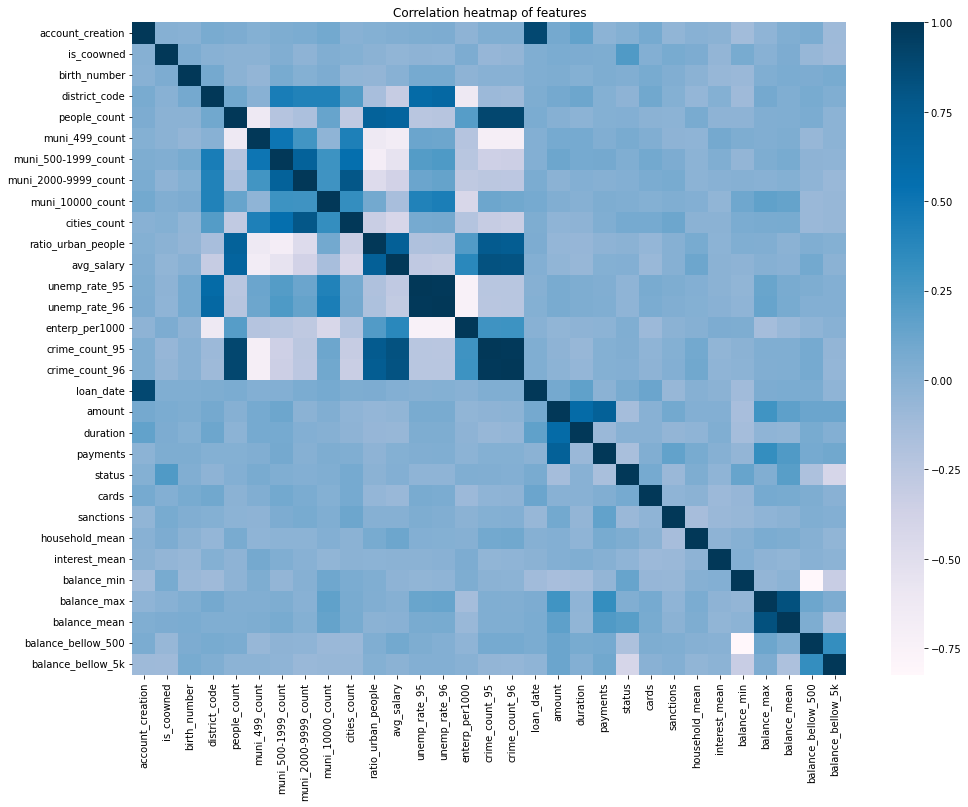

In [422]:
# create correlation matrix
corr_matrix = df.corr(method="spearman");

# create correlation heatmap
plt.figure(figsize=(16.0, 12.0))
plt.title("Correlation heatmap of features")
a = sb.heatmap(corr_matrix, linecolor='black', cmap='PuBu');
plt.show();

As we can see, most features aren't very correlated.

### ANOVA test

We will use this ANOVA test to see which features are more correlated with the label (**status**).  
This will help us decide which feature to drop in each of the pairs mentioned previously.

In [423]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

def do_anova(cols):
    # apply selectKBest to select top features
    best_features = SelectKBest(score_func=f_classif, k='all')
    df_cut = df[cols]
    fit = best_features.fit(df_cut, df["status"])

    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(df_cut.columns)

    # concat 2 dataFrame for better visualization
    feature_score = pd.concat([dfcolumns, dfscores], axis=1)
    feature_score.columns = ["Features", "Score"]
    return feature_score.sort_values(by="Score", ascending=False)

### Client

In [424]:
def parseYear(x):
    return x // 10000

def parseMonth(x):
    return x // 100 % 100

def parseDay(x):
    return x % 100

#### Work with client's birth_number

From this attribute we can extract the client's date of birth and gender.

<AxesSubplot:xlabel='is_male', ylabel='count'>

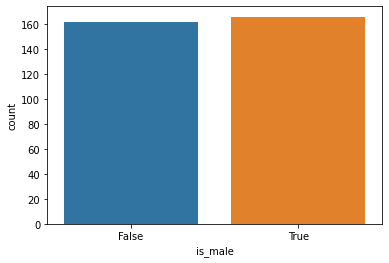

In [425]:
def identify_gender(row):
    birth = row['birth_number']
    month = (birth // 100) % 100
    return False if month > 12 else True

# create a new gender column
df['is_male'] = df.apply(identify_gender, axis=1)
df_test['is_male'] = df_test.apply(identify_gender, axis=1)

sb.countplot(x="is_male", data=df)

The genre distribution of clients who asked for loans is almost 50/50.

From the date of birth, we can derive the client's age.

In [426]:
def identify_year(df):
    def identify_year_inner(row):
        birth = row['birth_number']
        year = birth // 10000
        return year

    # create a new age column with client's age in year
    # dataset is from 99
    df['client_age'] = 99 - df.apply(identify_year_inner, axis=1)
    return df

df = identify_year(df)
df_test = identify_year(df_test)

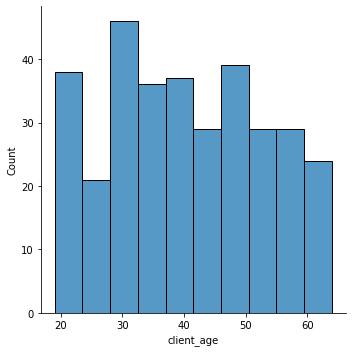

In [427]:
sb.displot(x="client_age", data=df)

<AxesSubplot:xlabel='client_age', ylabel='balance_mean'>

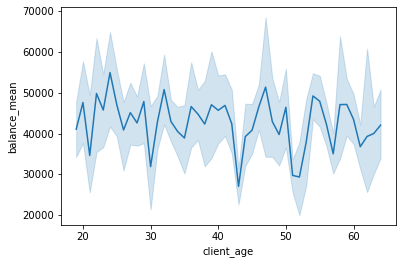

In [428]:
sb.lineplot(x="client_age", y="balance_mean", data=df)

There doesn't seem to be much balance differences between ages.

#### Discretize client ages

In [429]:
# discretize ages
def discretize_ages(df):
    age_bins=[0, 20, 29, 39, 49, 66, 150]
    labels=['0-19', '20-29', '30-39', '40-49', '50-65', 'retired']
    df['client_age_disc'] = pd.cut(x=df['client_age'], bins=age_bins, labels=labels)

discretize_ages(df)
discretize_ages(df_test)
df['client_age_disc']

0      50-65
1      30-39
2      50-65
3      50-65
4      20-29
       ...  
323    20-29
324    50-65
325    40-49
326    40-49
327    30-39
Name: client_age_disc, Length: 328, dtype: category
Categories (6, object): ['0-19' < '20-29' < '30-39' < '40-49' < '50-65' < 'retired']

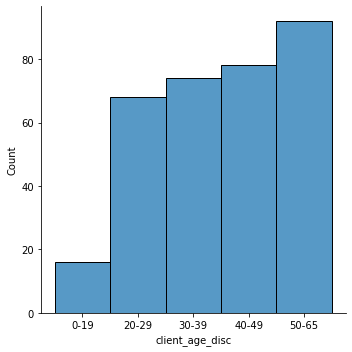

In [430]:
sb.displot(x="client_age_disc", data=df)

#### Deal with categorical client age discritization.

_client_age_ is a categorical value. Each category represents a range. This ranges can be divided into 2 attributes: the start and the end of the range.

In [431]:
def uncat_age_bins(df):
    def uncat_age_bins_inner(row, is_begin=True):
        age = row['client_age_disc']
        if age == 'retired':
            return 66 if is_begin else 150
        return age.split('-')[0 if is_begin else 1]
    
    df['age_start'] = df.apply(uncat_age_bins_inner, axis=1).astype(int)
    df['age_end'] = df.apply(lambda x: uncat_age_bins_inner(x, False), axis=1).astype(int)
    
uncat_age_bins(df)
uncat_age_bins(df_test)
df[["age_start", "age_end"]].head()

,age_start,age_end
0,50,65
1,30,39
2,50,65
3,50,65
4,20,29


Since there is a clear progression in ages, we can also encode this using label encoding.

In [432]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(['0-19', '20-29', '30-39', '40-49', '50-65', 'retired'])

df["client_age_label"] = le.transform(df['client_age_disc'])
df_test["client_age_label"] = le.transform(df_test['client_age_disc'])
df["client_age_label"].head()

0    4
1    2
2    4
3    4
4    1
Name: client_age_label, dtype: int64

#### Client attributes analysis

In [433]:
do_anova(["birth_number", "is_male", "client_age", "age_start", "age_end", "client_age_label"])

,Features,Score
4,age_end,1.140212
3,age_start,1.013200
5,client_age_label,0.879746
2,client_age,0.366472
0,birth_number,0.354014
1,is_male,0.164932


We can see that the client's age and genre don't seem to have a big impact on the result of the loans. The discritization of ages into **start** and **end** have a bigger impact than the label encoded ones.

From these, we'll only keep the _age\_start_ and _age\_end_ attributes.

In [434]:
df.drop(['birth_number', 'is_male', 'client_age', 'client_age_disc', 'client_age_label'], axis=1, inplace=True)
df_test.drop(['birth_number', 'is_male', 'client_age', 'client_age_disc', 'client_age_label'], axis=1, inplace=True)

### District

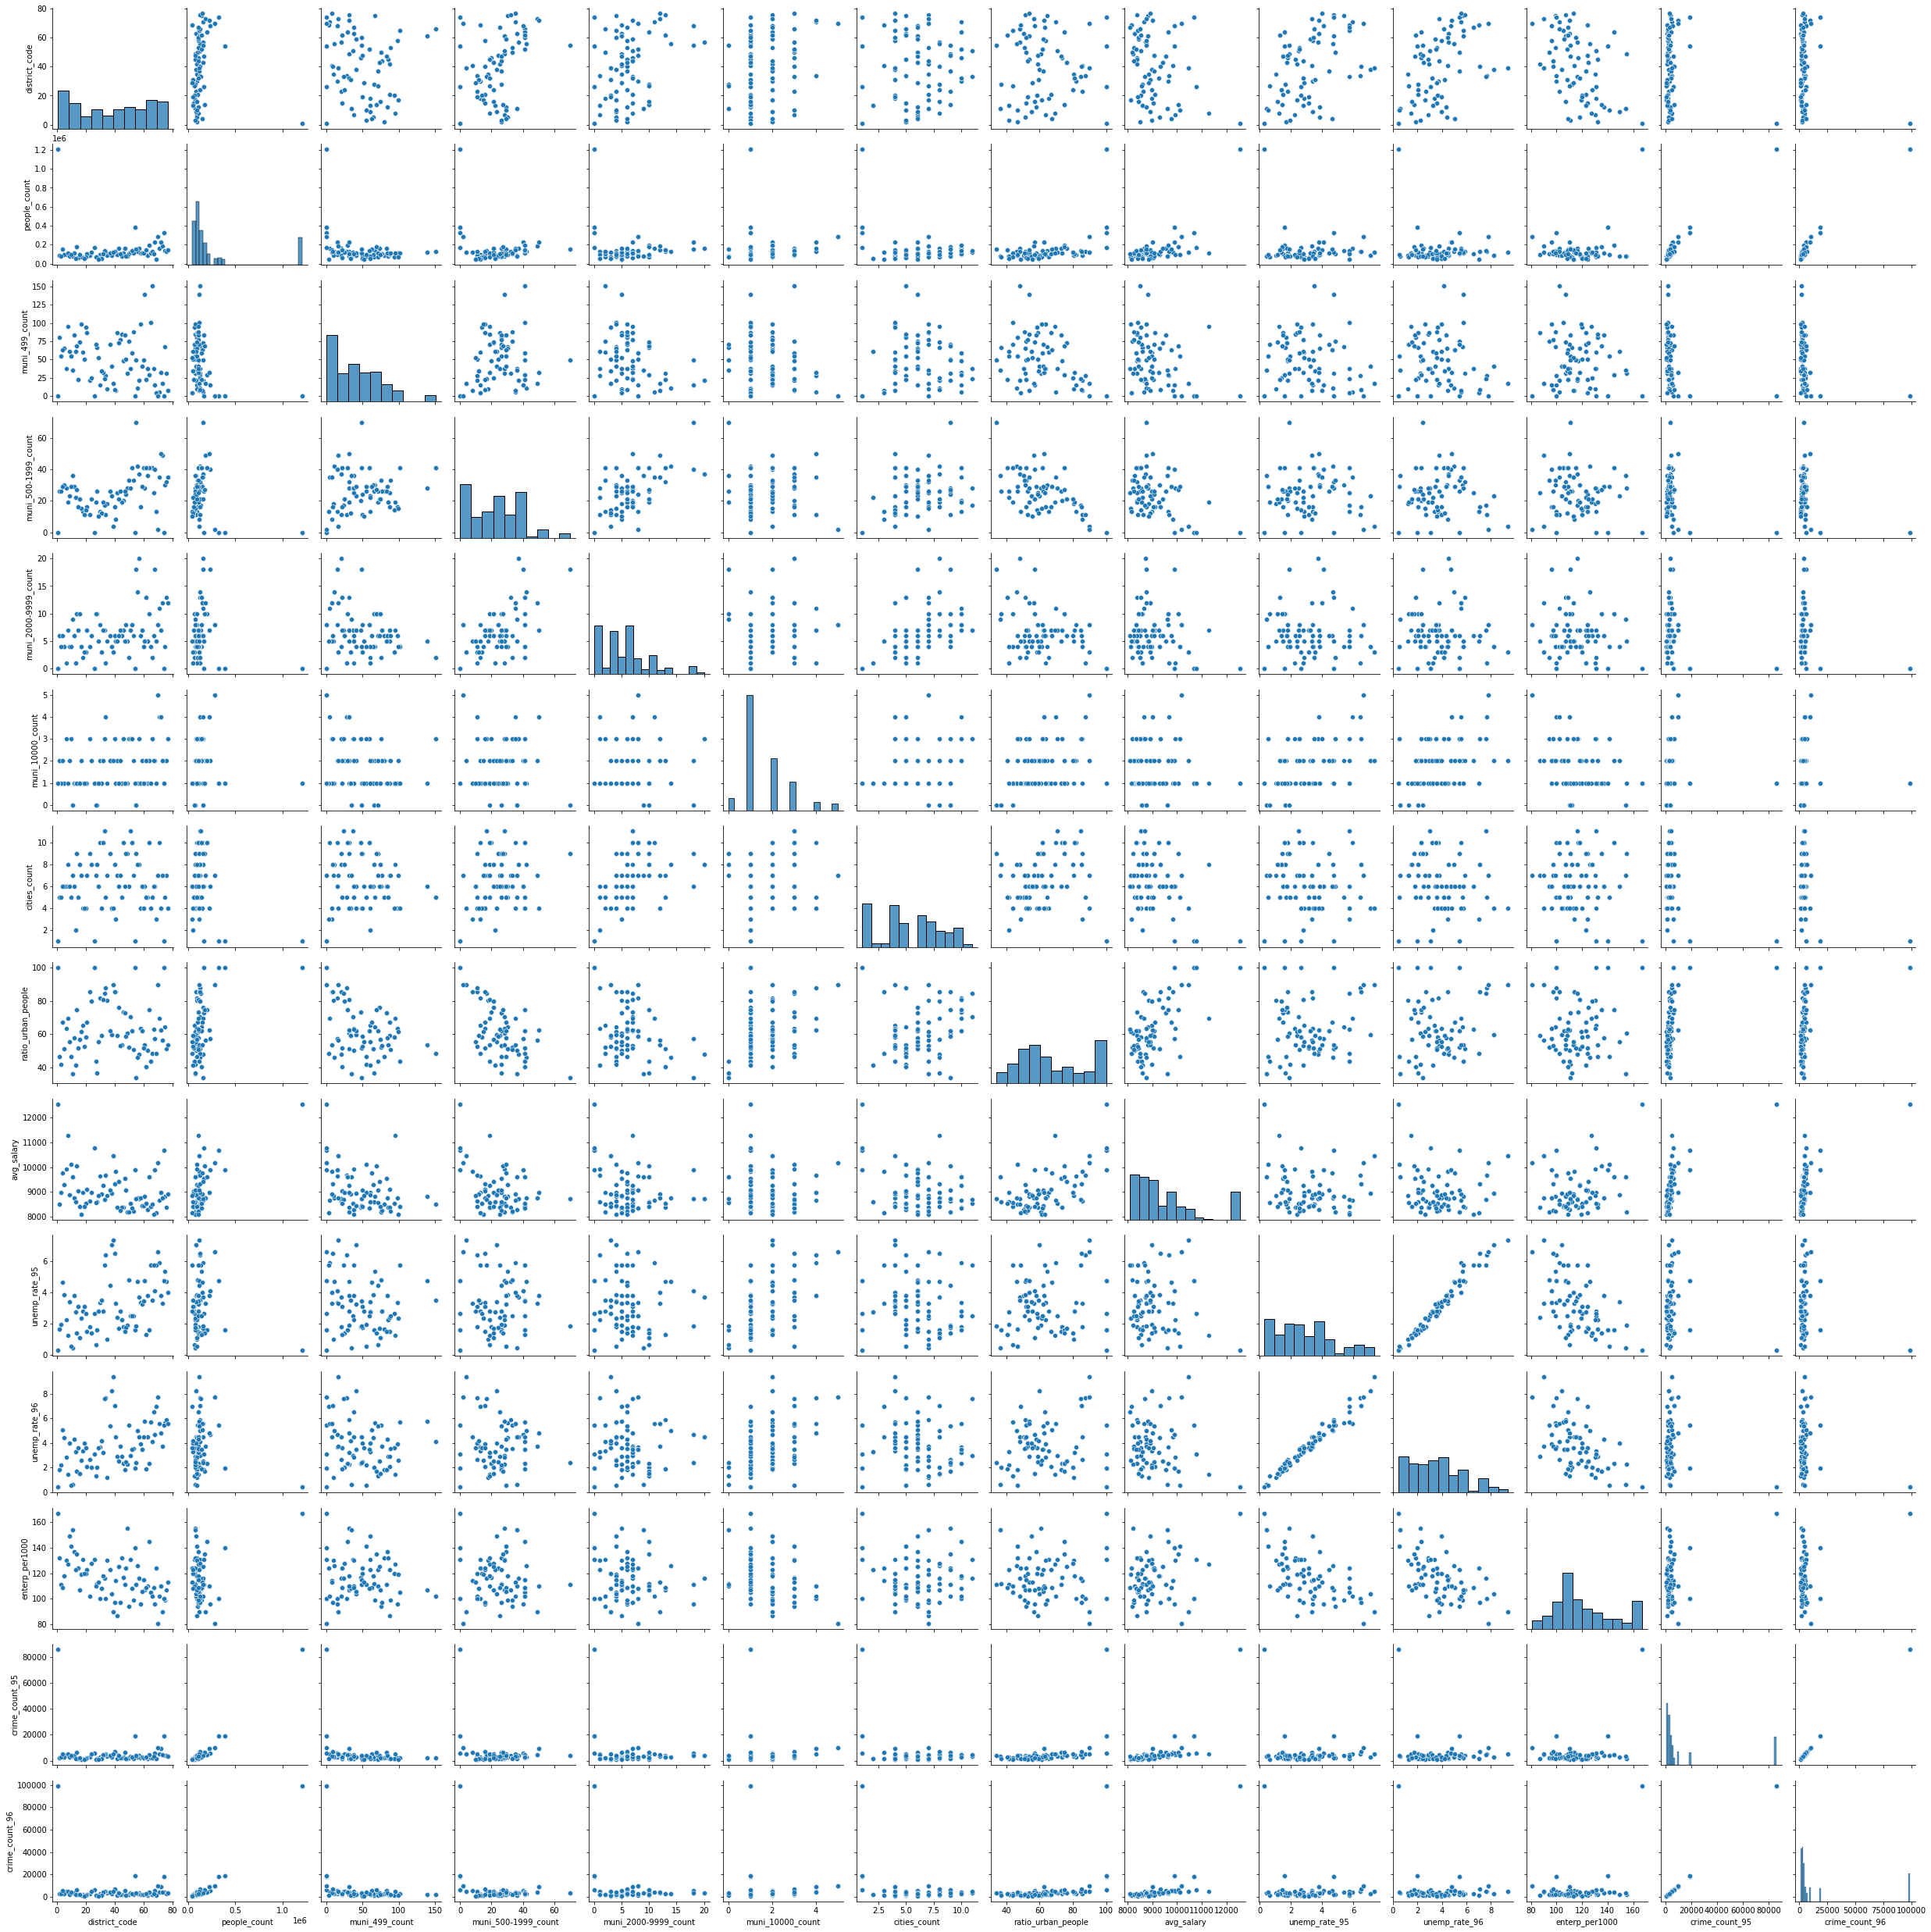

In [435]:
district_cols = ["district_code", "district_name", "region", "people_count",
               "muni_499_count", "muni_500-1999_count", "muni_2000-9999_count",
               "muni_10000_count", "cities_count", "ratio_urban_people",
               "avg_salary", "unemp_rate_95", "unemp_rate_96", "enterp_per1000",
               "crime_count_95", "crime_count_96"]
sb.pairplot(df[district_cols])

#### Unemployment rate

<AxesSubplot:xlabel='unemp_rate_95', ylabel='unemp_rate_96'>

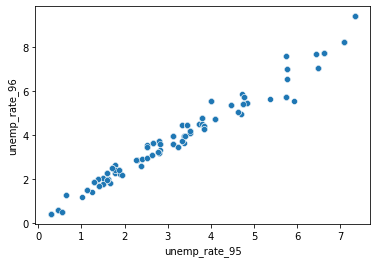

In [436]:
sb.scatterplot(x=df["unemp_rate_95"], y=df["unemp_rate_96"])

The relation between the unemployment rated in 1995 and 1996 in nearlly linear (with few outliers from the trend).

From these two, we could drop the most recent (1996), as it is less likely to affect the loan decisions. This is because the decisions on loans were taken considering only data relative to before the loan was conceded.

We decided that this 2 attributes could be joined into a single one, _unem_growth_, representing the growth of the unemployment rate.

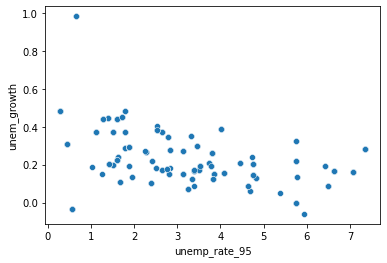

In [437]:
def unemp_rate(df, draw=True):
    df["unem_growth"] = (df["unemp_rate_96"]/df["unemp_rate_95"]) - 1.0
    if draw:
        sb.scatterplot(x=df["unemp_rate_95"], y=df["unem_growth"])
    
unemp_rate(df)
unemp_rate(df_test, False)


In [438]:
do_anova(["unemp_rate_95", "unemp_rate_96", "unem_growth"])

,Features,Score
0,unemp_rate_95,0.258757
1,unemp_rate_96,0.238824
2,unem_growth,0.118294


None of these attributes seem to be very good. Still, we're going to keep the unemployment growth attribute.

In [439]:
df.drop(["unemp_rate_95", "unemp_rate_96"], axis=1, inplace=True)
df_test.drop(["unemp_rate_95", "unemp_rate_96"], axis=1, inplace=True)

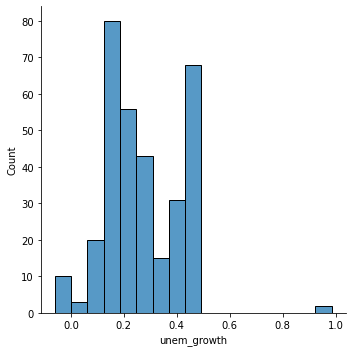

In [440]:
sb.displot(df["unem_growth"])

#### Crime count

,issuance_freq,account_creation,is_coowned,district_code,district_name,region,people_count,muni_499_count,muni_500-1999_count,muni_2000-9999_count,muni_10000_count,cities_count,ratio_urban_people,avg_salary,enterp_per1000,crime_count_95,crime_count_96,loan_date,amount,duration,payments,status,cards,sanctions,household_mean,interest_mean,balance_min,balance_max,balance_mean,balance_bellow_500,balance_bellow_5k,age_start,age_end,unem_growth
17,monthly issuance,930628,False,1,Hl.m. Praha,Prague,1204953,0,0,0,1,1,100.0,12541,167,85677.0,99107,931216,38148,12,3179,1,0,0,0.0,219.000000,900.0,62324.6,37462.093103,0.0,1.0,30,39,0.482759
19,monthly issuance,930610,False,54,Brno - mesto,south Moravia,387570,0,0,0,1,1,100.0,9897,140,18721.0,18696,931223,75624,24,3151,-1,0,0,14291.0,186.900000,400.0,89754.8,50009.908696,1.0,1.0,40,49,0.225000
20,monthly issuance,930226,True,1,Hl.m. Praha,Prague,1204953,0,0,0,1,1,100.0,12541,167,85677.0,99107,940105,80952,24,3373,1,0,0,0.0,255.247059,1100.0,67529.6,32590.624074,0.0,1.0,50,65,0.482759
21,monthly issuance,930226,True,1,Hl.m. Praha,Prague,1204953,0,0,0,1,1,100.0,12541,167,85677.0,99107,940105,80952,24,3373,1,0,0,5940.0,282.083333,1100.0,67529.6,33312.538889,0.0,1.0,50,65,0.482759
22,monthly issuance,930227,False,1,Hl.m. Praha,Prague,1204953,0,0,0,1,1,100.0,12541,167,85677.0,99107,940110,24516,12,2043,1,0,0,7085.0,143.000000,200.0,125254.2,55582.226027,2.0,3.0,40,49,0.482759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,monthly issuance,950508,False,1,Hl.m. Praha,Prague,1204953,0,0,0,1,1,100.0,12541,167,85677.0,99107,961111,110136,24,4589,1,0,0,1326.0,136.736364,400.0,140542.8,50815.804762,1.0,1.0,40,49,0.482759
316,monthly issuance,960609,True,1,Hl.m. Praha,Prague,1204953,0,0,0,1,1,100.0,12541,167,85677.0,99107,961122,228276,36,6341,1,0,2,0.0,195.844737,500.0,60236.6,41402.135000,0.0,1.0,30,39,0.482759
319,monthly issuance,960122,False,54,Brno - mesto,south Moravia,387570,0,0,0,1,1,100.0,9897,140,18721.0,18696,961128,179328,48,3736,1,0,0,0.0,128.935714,200.0,81614.7,44093.971154,1.0,1.0,20,29,0.225000
323,monthly issuance,950121,True,72,Olomouc,north Moravia,226122,32,50,7,4,4,62.6,8994,110,9672.0,9208,961212,155616,48,3242,1,0,0,9810.0,213.500000,200.0,75294.1,44197.509884,1.0,1.0,20,29,0.260526


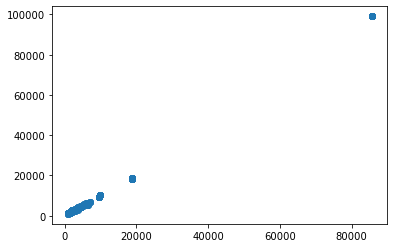

In [441]:
plt.scatter(df["crime_count_95"], df["crime_count_96"])

df[df["crime_count_95"] > 8000]

Although there is a big gap increase on the total number of crimes commited after 20000 crimes, from the plot, it can be concluded that there is a approximatelly linear correlation between the number of crimes commited in 1995 and 1996.

There are 3 regions with a much higher number of commited crimes: Prague, south Moravia, north Moravia. Even in the case of these regions, the relation is almost linear.

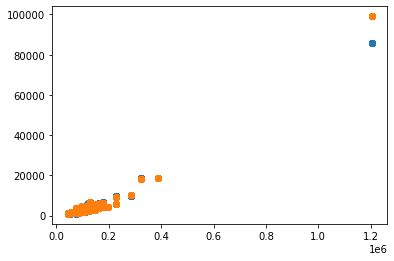

In [442]:
plt.scatter(df["people_count"], df["crime_count_95"])
plt.scatter(df["people_count"], df["crime_count_96"])

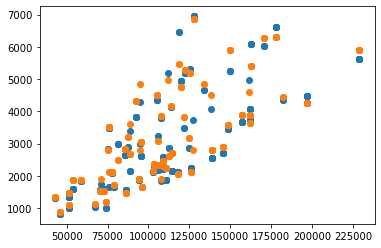

In [443]:
tmp = df[df["crime_count_95"] < 8000]
plt.scatter(tmp["people_count"], tmp["crime_count_95"])

tmp2 = df[df["crime_count_96"] < 8000]
plt.scatter(tmp2["people_count"], tmp2["crime_count_96"])

As expected, the higher the population, the more crimes are commited and this remains true for both years.

This means that it isn't a very useful information in this form. We can convert both crime counts to crime commited per 1000 habitants and use that to calculate the _crime growth_.

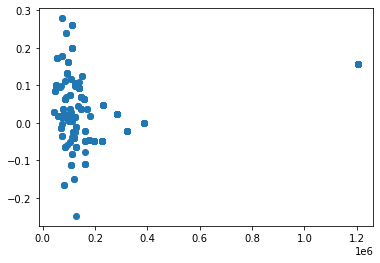

In [444]:
def crime_per1000(df):
    crime_per1000_95 = df["crime_count_95"] / (df["people_count"] / 1000)
    crime_per1000_96 = df["crime_count_96"] / (df["people_count"] / 1000)

    df["crime_growth"] = (crime_per1000_96/crime_per1000_95) - 1.0

crime_per1000(df)
crime_per1000(df_test)
plt.scatter(df["people_count"], df["crime_growth"])

This new attribute, _crime\_growth_, isn't directly related to the population size.

In [445]:
do_anova(["crime_count_95", "crime_count_96", "crime_growth"])

,Features,Score
2,crime_growth,0.129845
0,crime_count_95,0.032578
1,crime_count_96,0.030833


Although the crime growth appears to be a better attribute than its counterparts, it is still a not very useful one.  
We're going to drop the crime counts.

In [446]:
df.drop(["crime_count_95", "crime_count_96"], axis=1, inplace=True)
df_test.drop(["crime_count_95", "crime_count_96"], axis=1, inplace=True)

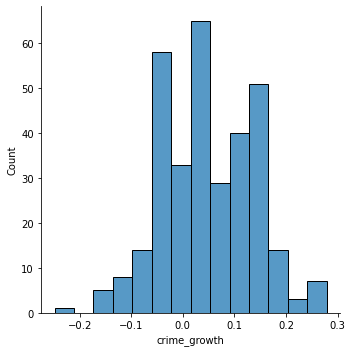

In [447]:
sb.displot(df["crime_growth"])

#### Skewness

Some attributes are heavily _skewed_. To take care of this, we apply `np.log` to the attribute.

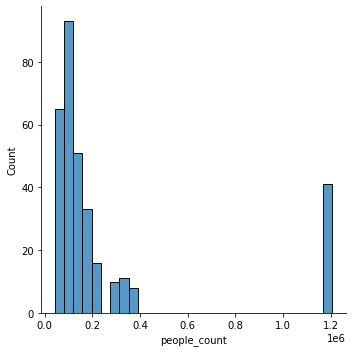

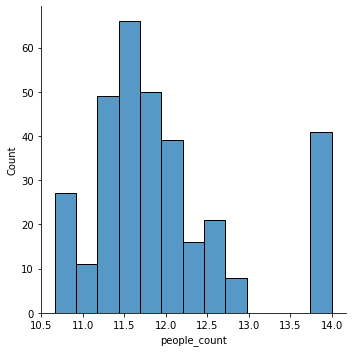

In [448]:
sb.displot(df["people_count"])

df["people_count"] = np.log(df["people_count"])
df_test["people_count"] = np.log(df_test["people_count"])
sb.displot(df["people_count"])

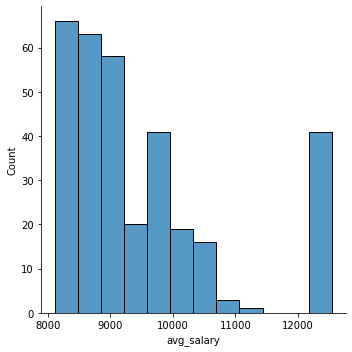

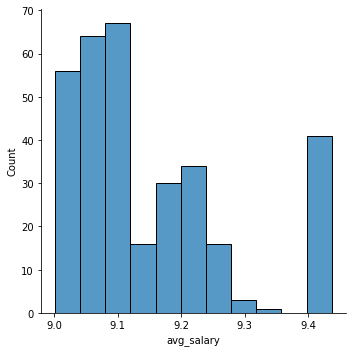

In [449]:
sb.displot(df["avg_salary"])

df["avg_salary"] = np.log(df["avg_salary"])
df_test["avg_salary"] = np.log(df_test["avg_salary"])
sb.displot(df["avg_salary"])

#### District categorical data

In [450]:
from category_encoders import TargetEncoder
enc = TargetEncoder(cols=['district_name'])
training_numeric_dataset = enc.fit_transform(df.drop('status', axis=1), df.status)
training_numeric_dataset["district_name"]

0      0.719512
1      0.966565
2      0.986698
3      0.994955
4      0.986698
         ...   
323    0.600015
324    0.510411
325    0.799990
326    0.667020
327    0.193507
Name: district_name, Length: 328, dtype: float64

Both name and region are categorical data relating to regions.

In [451]:
print("Number of different 'code' values:", len(df['district_code'].value_counts()))
print("Number of different 'name' values:", len(df['district_name'].value_counts()))

Number of different 'code' values: 73
Number of different 'name' values: 73


We can see that there is a direct association between the **code** and **name** attributes. This means they are redundant and we don't have to deal with the **name** attribute.

There is a problem with this. The **code** attributes are integers which indirectly imply an order, even though the names of the regions are nominal features. Using one-hot or binary enconding for this would generate too many attribute, so it was decided that target encoding would be used.

In [452]:
from category_encoders import TargetEncoder

st = df["status"]
st_test = df_test["status"]

enc = TargetEncoder(cols=['district_name'])
df = enc.fit_transform(df.drop('status', axis=1), df["status"])
df["status"] = st
df_test = enc.transform(df_test.drop('status', axis=1))
df_test["status"] = st_test

df["district_name"]

0      0.719512
1      0.966565
2      0.986698
3      0.994955
4      0.986698
         ...   
323    0.600015
324    0.510411
325    0.799990
326    0.667020
327    0.193507
Name: district_name, Length: 328, dtype: float64

In [453]:
df.drop(['district_code'], axis=1, inplace=True)
df.rename(columns={'district_name': 'district'}, inplace=True)
df_test.drop(['district_code'], axis=1, inplace=True)
df_test.rename(columns={'district_name': 'district'}, inplace=True)

The **region** feature is categorial and there is no order associated. This means this attribute should be encoded in order to remove it's categorical nature and still remain unordered. One-Hot encoding could be used for simplicity, but Binary enconding is better.

In [454]:
df['region'].value_counts()

south Moravia      68
north Moravia      51
Prague             41
east Bohemia       40
central Bohemia    37
south Bohemia      31
west Bohemia       30
north Bohemia      30
Name: region, dtype: int64

In [455]:
from category_encoders import BinaryEncoder

def enc_region(df):
    encoder = BinaryEncoder(cols=['region'])
    return encoder.fit_transform(df)

df = enc_region(df)
df_test = enc_region(df_test)
df[["region_0", "region_1", "region_2", "region_3"]].head()

,region_0,region_1,region_2,region_3
0,0,0,0,1
1,0,0,1,0
2,0,0,1,0
3,0,0,1,1
4,0,1,0,0


#### ANOVA test

In [457]:
district_cols = ["district", "people_count", "region_0", "region_1", "region_2",
                 "region_3", "muni_499_count", "muni_500-1999_count",
                 "muni_2000-9999_count", "muni_10000_count", "cities_count",
                 "ratio_urban_people", "avg_salary", "enterp_per1000"]
do_anova(district_cols)

,Features,Score
0,district,87.435809
2,region_0,3.141008
10,cities_count,2.233981
6,muni_499_count,1.809475
4,region_2,1.732369
5,region_3,0.647649
3,region_1,0.590498
9,muni_10000_count,0.527834
13,enterp_per1000,0.432246
7,muni_500-1999_count,0.408795


The **district** attribute appears to have a fenomenal performance. From these, we'll keep the best ones: district, cities count, municipalities with less than 500 habitants, and the region (including its encoding).

In [458]:
district_to_drop = ["people_count", "muni_500-1999_count", "muni_2000-9999_count",
                    "muni_10000_count", "ratio_urban_people", "avg_salary",
                    "enterp_per1000"]
df.drop(district_to_drop, axis=1, inplace=True)
df_test.drop(district_to_drop, axis=1, inplace=True)

### Loan

#### Loan date

Separa the loan date into a month and year, so it can be explored later: maybe more loans are granted during winter or summer time.

In [459]:
# separate the loan date into loan year and loan month
def loan_ym(df):
    df['year_loan'] = df['loan_date'].apply(parseYear)
    df['month_loan'] = df['loan_date'].apply(parseMonth)
    
loan_ym(df)
loan_ym(df_test)

In [460]:
do_anova(["loan_date", "year_loan", "month_loan"])

,Features,Score
2,month_loan,5.804730
0,loan_date,0.276866
1,year_loan,0.193184


<AxesSubplot:xlabel='year_loan', ylabel='count'>

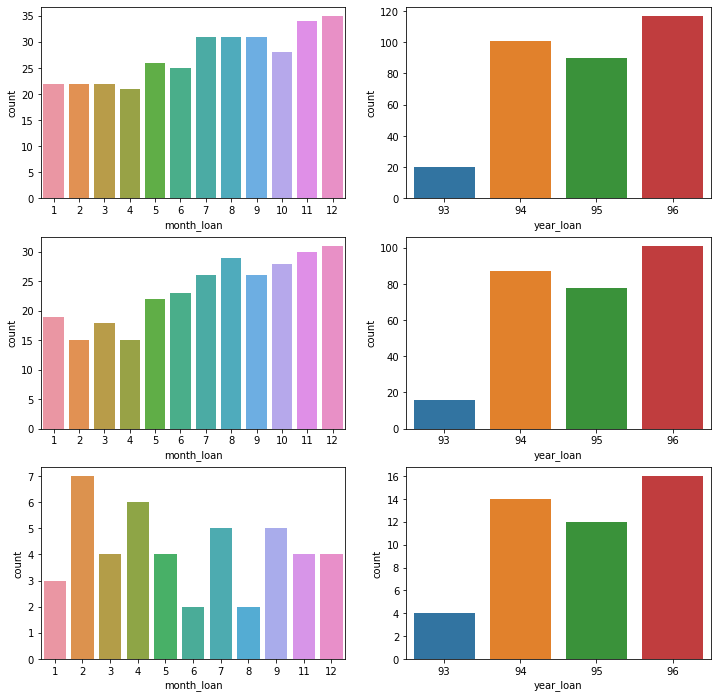

In [461]:
fig, ax = plt.subplots(3,2)
fig.set_size_inches(12, 12)
sb.countplot(data=df, x='month_loan', ax=ax[0][0])
sb.countplot(data=df, x='year_loan', ax=ax[0][1])
sb.countplot(data=df[df["status"] == 1], x='month_loan', ax=ax[1][0])
sb.countplot(data=df[df["status"] == 1], x='year_loan', ax=ax[1][1])
sb.countplot(data=df[df["status"] == -1], x='month_loan', ax=ax[2][0])
sb.countplot(data=df[df["status"] == -1], x='year_loan', ax=ax[2][1])


The proportion of accepted/declined loans per year doesn't suffer many changes. We can see that the trend is that there are more loan requests the deeper into the year we are. More loans are accepted towards the end of the year, but the rejected loans show a somewhat erractic behavior.

We should drop both the _year\_loan_ and the _loan\_date_ fields as they have almost no correlation to the status.

In [462]:
df.drop(["year_loan", "loan_date"], axis=1, inplace=True)
df_test.drop(["year_loan", "loan_date"], axis=1, inplace=True)

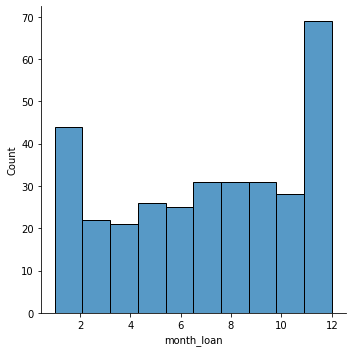

In [463]:
sb.displot(df["month_loan"])

The loan month isn't very skewed

#### Loan amount

Text(0, 0.5, 'total amount payed')

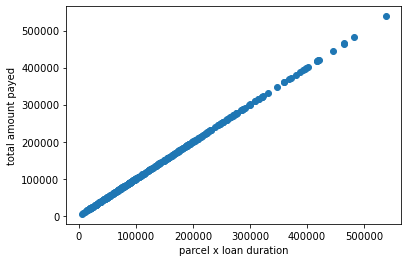

In [464]:
plt.scatter(df["payments"] * df["duration"], df["amount"])
plt.xlabel("parcel x loan duration")
plt.ylabel("total amount payed")

The loan amount is equal to its duration times the payments. We can see that they are very correlated.

In [465]:
do_anova(["payments", "duration", "amount"])

,Features,Score
0,payments,9.518871
2,amount,5.450596
1,duration,0.004079


The duration has a very low correlation with the status, but both _amount_ and _payments_ have a decent correlation with the _status_.

<AxesSubplot:xlabel='payments', ylabel='amount'>

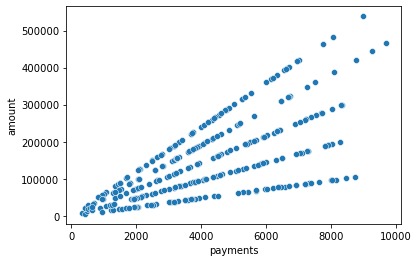

In [466]:
sb.scatterplot(x=df["payments"], y=df["amount"])

Although _payments_ and _amount_ are linearly related, there are multiple lines on the plot. We decided to only drop the duration.

In [467]:
df.drop(["duration"], axis=1, inplace=True)
df_test.drop(["duration"], axis=1, inplace=True)

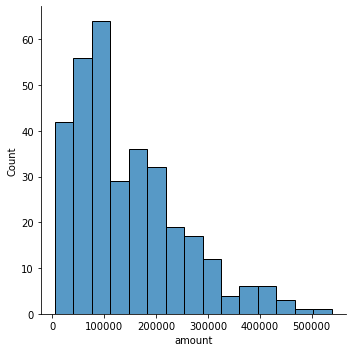

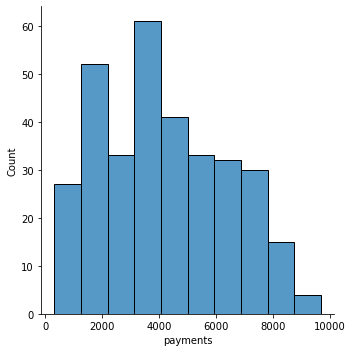

In [468]:
sb.displot(df["amount"])
sb.displot(df["payments"])

Neither attribute is very skewed.

### Transaction

In [469]:
do_anova(["sanctions", "household_mean", "interest_mean",
          "balance_min", "balance_max", "balance_mean",
          "balance_bellow_500", "balance_bellow_5k"])

,Features,Score
7,balance_bellow_5k,71.808531
6,balance_bellow_500,47.141053
3,balance_min,17.658363
5,balance_mean,12.747115
0,sanctions,3.412983
1,household_mean,0.830395
2,interest_mean,0.387150
4,balance_max,0.128700


There's a big difference between the importances of these attributes: the top 4 are a lot more important than the others.  
It was decided that the top 5 would be kept.

In [470]:
df.drop(["balance_max", "interest_mean", "household_mean"], axis=1, inplace=True)
df_test.drop(["balance_max", "interest_mean", "household_mean"], axis=1, inplace=True)

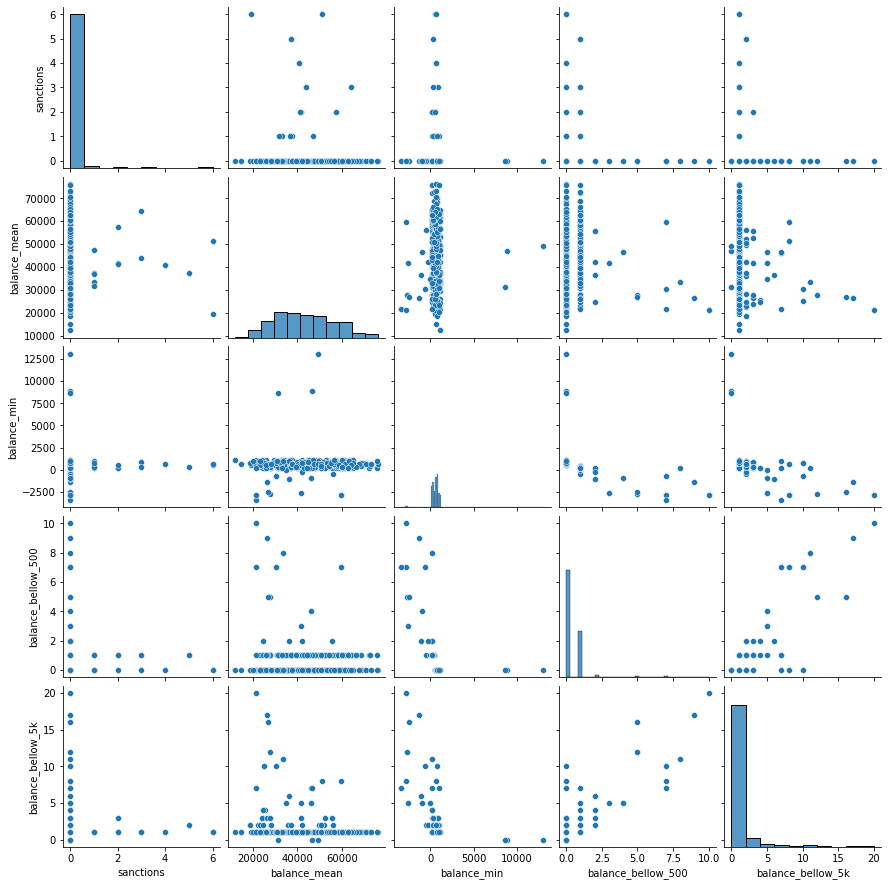

In [471]:
sb.pairplot(df[["sanctions", "balance_mean", "balance_min",
                "balance_bellow_500", "balance_bellow_5k"]])

The selected attributes aren't very correlated between themselves, with the exception of _balance\_bellow\_500_ and _balance\_bellow\_5k.

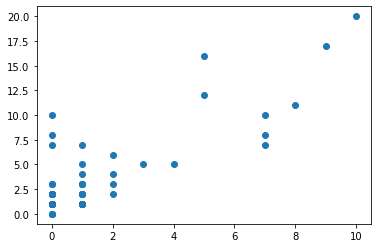

In [472]:
plt.scatter(df["balance_bellow_500"], df["balance_bellow_5k"])

Although these are the most correlated of the selected attributes, they aren't correlated enough for us to do anything.

### Account

#### Separate year and month

In [473]:
def account_ym(df):
    df['year_acc'] = df['account_creation'].apply(parseYear)
    df['month_acc'] = df['account_creation'].apply(parseMonth)

account_ym(df)
account_ym(df_test)
df[['month_acc', 'year_acc']].head()

,month_acc,year_acc
0,3,93
1,2,93
2,2,93
3,1,93
4,2,93


#### Issuance frequency

The frequency is categorical data. Let's look at the cardinality of the attribute and whether it has an implicit order.

In [474]:
df['issuance_freq'].value_counts()

monthly issuance              259
weekly issuance                51
issuance after transaction     18
Name: issuance_freq, dtype: int64

There are 3  possible values for the **frquency attribute**: _monthly issuance_, _weekly issuance_, _issuance_ after transation. There is an implicit order between weekly and monthly, but with _issuance after transation_ it isn't so obvious. It was decided that, since it is expected that people do more than 1 transaction per week, _issuance after transation_ also relates to the other 2 in terms of time.

When considering the time intervals between transations: _issuance after transation_ < _weekly issuance_ < _monthly issuance_.

There is also a magnitude difference between all of them, e.g.: monthly is around 4 times more frequent than weekly. This raises the issue of how much more frequent is _issuance after transaction_ than _weekly issuance_. Let's assume the _weekly issuance_ is 7 time less frequent.

Let's replace this categorical data by ordered integers:

In [475]:
def issuance_cat(df):
    df.replace({'issuance_freq':
                {'issuance after transaction': 1,
                 'weekly issuance': 7,
                 'monthly issuance': 30}
               }, inplace=True)

issuance_cat(df)
issuance_cat(df_test)
df['issuance_freq']

0       7
1      30
2      30
3      30
4       7
       ..
323    30
324    30
325    30
326    30
327    30
Name: issuance_freq, Length: 328, dtype: int64

#### Anova test

In [476]:
do_anova(['month_acc', 'year_acc',
          "account_creation", "issuance_freq"])

,Features,Score
0,month_acc,3.457941
3,issuance_freq,1.807382
1,year_acc,0.946966
2,account_creation,0.844121


The most important attributes (and the only one that will be kept from these) are the _month\_acc_ and the _issuance\_freq_.

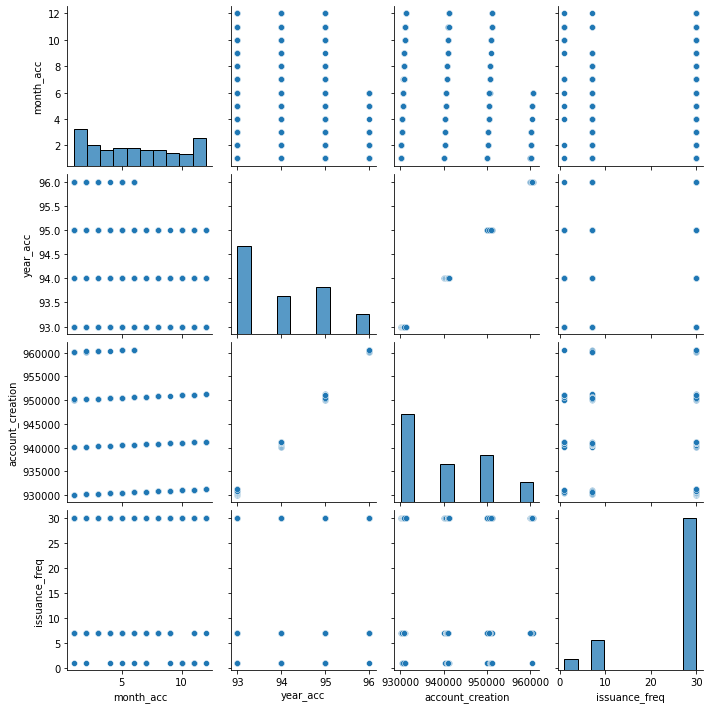

In [477]:
sb.pairplot(df[['month_acc', 'year_acc',
                "account_creation", "issuance_freq"]])

The attributes aren't very correlated, with the exception of the year and date of the account creation (as expected), but these will be dropped.

In [478]:
df.drop(['year_acc', "account_creation"], axis=1, inplace=True)
df_test.drop(['year_acc', "account_creation"], axis=1, inplace=True)

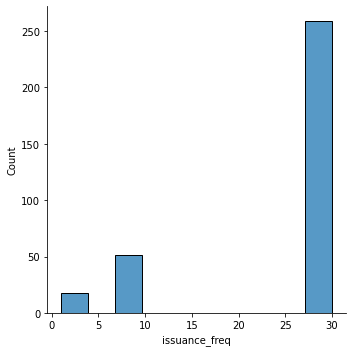

In [479]:
sb.displot(df["issuance_freq"])

This attribute is skewed, but we can't do anything about it.

### Disposition

In [480]:
do_anova(["is_coowned"])

,Features,Score
0,is_coowned,16.565041


This attribute has a high correlation with the loan status.

### Card

In [481]:
do_anova(["cards"])

,Features,Score
0,cards,1.745876


The number of cards in an account has an OK correlation with the loan status. We will keep this value.

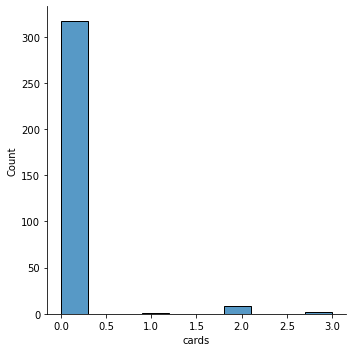

In [482]:
sb.displot(df["cards"])

## Work with filtered attributes

In [484]:
df.head()

,issuance_freq,is_coowned,district,region_0,region_1,region_2,region_3,muni_499_count,cities_count,amount,payments,cards,sanctions,balance_min,balance_mean,balance_bellow_500,balance_bellow_5k,age_start,age_end,unem_growth,crime_growth,status,month_loan,month_acc
0,7,False,0.719512,0,0,0,1,15,10,96396,8033,0,0,1100.0,12250.000000,0.0,1.0,50,65,0.085799,-0.060637,-1,7,3
1,30,False,0.966565,0,0,1,0,48,10,165960,4610,0,0,700.0,52083.859459,0.0,2.0,30,39,0.290503,-0.082691,1,7,2
2,30,False,0.986698,0,0,1,0,85,5,127080,2118,0,0,800.0,30060.954167,0.0,1.0,50,65,0.267544,0.020192,1,7,2
3,30,False,0.994955,0,0,1,1,69,9,105804,2939,0,0,1000.0,41297.480000,0.0,1.0,50,65,0.204225,-0.046790,1,8,1
4,7,False,0.986698,0,1,0,0,38,5,274740,4579,0,0,600.0,57188.211111,0.0,1.0,20,29,0.192612,-0.065301,1,9,2


### Correlation matrix

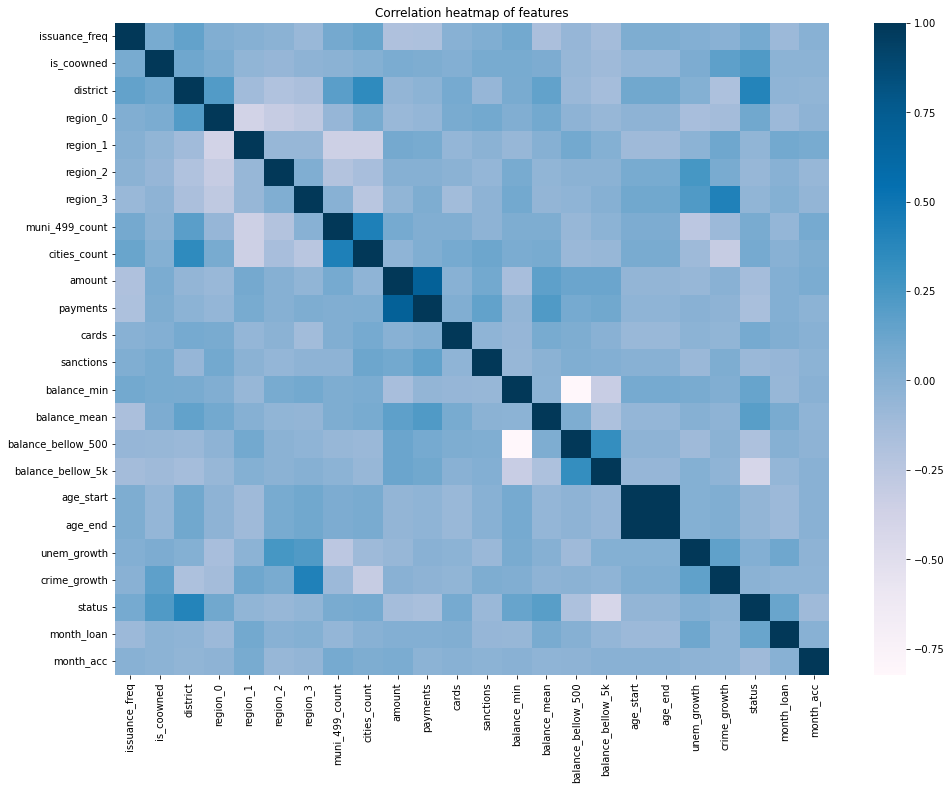

In [488]:
# create correlation matrix
corr_matrix = df.corr(method="spearman");

# create correlation heatmap
plt.figure(figsize=(16.0, 12.0))
plt.title("Correlation heatmap of features")
a = sb.heatmap(corr_matrix, linecolor='black', cmap='PuBu');
plt.show();

In [487]:
do_anova(list(df.columns))

/usr/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


,Features,Score
21,status,inf
2,district,87.435809
16,balance_bellow_5k,71.808531
15,balance_bellow_500,47.141053
13,balance_min,17.658363
1,is_coowned,16.565041
14,balance_mean,12.747115
10,payments,9.518871
22,month_loan,5.804730
9,amount,5.450596


## Deal with categorical data

In [483]:
df.dtypes

issuance_freq           int64
is_coowned               bool
district              float64
region_0                int64
region_1                int64
region_2                int64
region_3                int64
muni_499_count          int64
cities_count            int64
amount                  int64
payments                int64
cards                   int64
sanctions               int64
balance_min           float64
balance_mean          float64
balance_bellow_500    float64
balance_bellow_5k     float64
age_start               int64
age_end                 int64
unem_growth           float64
crime_growth          float64
status                  int64
month_loan              int64
month_acc               int64
dtype: object

There are no categorical attributes left.

## Classification

### Split data

In [97]:
def getXy(df):
    # inputs
    X = df.drop(["status"], axis=1)
    # target
    y = df["status"]
    return (X, y)

X_train, y_train = getXy(df)
X_test, y_test = getXy(df_test)

#### Scale data

In [98]:
from sklearn import preprocessing

def scale(X):
    scaler = preprocessing.StandardScaler().fit(X)
    return scaler.transform(X)

X_train_scaled = scale(X_train)
X_test_scaled = scale(X_test)

Note that we scaled our data. We did this because we need it to obtain better results on distance-based models: K-NN and SVC. This doesn't affect tree-based algorithms so we do it here.

In [99]:
from sklearn.model_selection import StratifiedKFold

k = 10
kf = StratifiedKFold(n_splits=k)

We will be using **Stratified K-Fold with 10 folds** for our cross-validations.

### Establishing a baseline

Let's establish a baseline for our classifiers.

In [100]:
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

baseline_clfs = [
    {"name": "Decision tree", "clf": DecisionTreeClassifier(), "scale": False},
    {"name": "K-NN", "clf": KNeighborsClassifier(), "scale": True},
    {"name": "SVM", "clf": SVC(), "scale": True},
    {"name": "Logistic Regression", "clf": LogisticRegression(), "scale": True},
    {"name": "Naive Bayes", "clf": GaussianNB(), "scale": False},
    {"name": "Random Forest", "clf": RandomForestClassifier(), "scale": False},
]

scoring = {"accuracy": "accuracy",
           "precision": "precision_weighted",
           "recall": "recall_weighted",
           "f1": "f1_weighted",
           "roc_auc": "roc_auc"}

# save classifier information in DataFrame: name, score, fit_time, score_time
baseline_df = pd.DataFrame()
for clf_entry in baseline_clfs:
    Xt = X_train_scaled if clf_entry["scale"] else X_train 
    scores = cross_validate(clf_entry["clf"], Xt, y_train, scoring=scoring, cv=kf, n_jobs=configNJobs)
    info = scores | {"classifier": [clf_entry["name"]] * k}
    baseline_df = baseline_df.append(pd.DataFrame(info))

baseline_df.head()

/usr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined a

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc,classifier
0,0.006226,0.007437,0.727273,0.784545,0.727273,0.751023,0.592857,Decision tree
1,0.005616,0.004477,0.818182,0.818182,0.818182,0.818182,0.646429,Decision tree
2,0.005436,0.004966,0.939394,0.943434,0.939394,0.932863,0.800000,Decision tree
3,0.005443,0.004715,0.818182,0.818182,0.818182,0.818182,0.646429,Decision tree
4,0.005969,0.005337,0.787879,0.837424,0.787879,0.806351,0.710714,Decision tree


#### Accuracy (score)

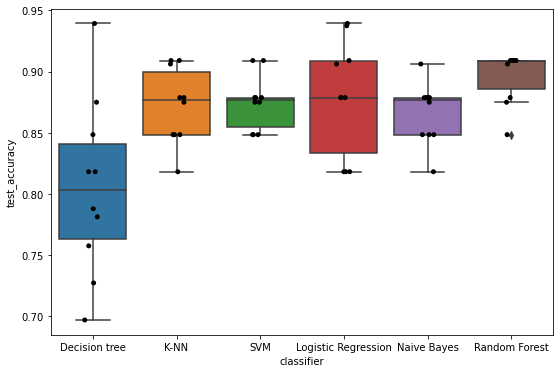

In [101]:
plt.figure(figsize=(9, 6))
sb.boxplot(x="classifier", y="test_accuracy", data=baseline_df);
sb.stripplot(x='classifier', y='test_accuracy', data=baseline_df, jitter=True, color='black');

#### Precision

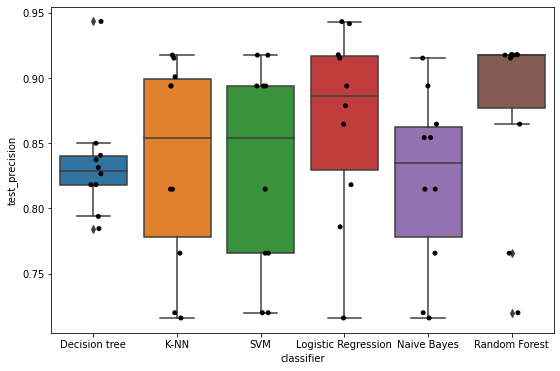

In [102]:
plt.figure(figsize=(9, 6))
sb.boxplot(x="classifier", y="test_precision", data=baseline_df);
sb.stripplot(x='classifier', y='test_precision', data=baseline_df, jitter=True, color='black');

#### Recall

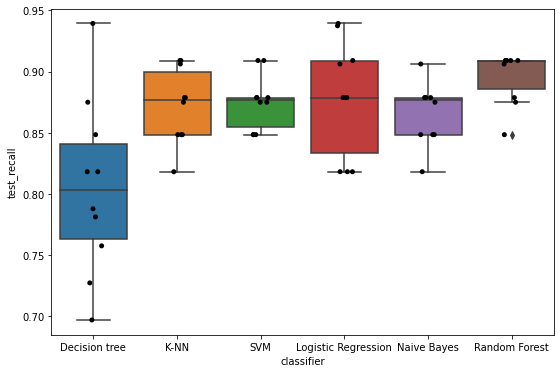

In [103]:
plt.figure(figsize=(9, 6))
sb.boxplot(x="classifier", y="test_recall", data=baseline_df);
sb.stripplot(x='classifier', y='test_recall', data=baseline_df, jitter=True, color='black');

#### F1-score

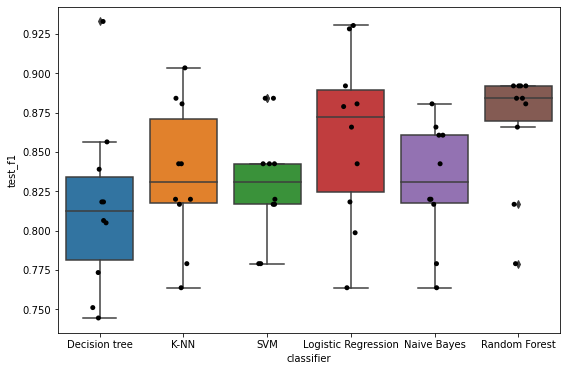

In [104]:
plt.figure(figsize=(9, 6))
sb.boxplot(x="classifier", y="test_f1", data=baseline_df);
sb.stripplot(x='classifier', y='test_f1', data=baseline_df, jitter=True, color='black');

#### Roc-Curve Area Under the Curve

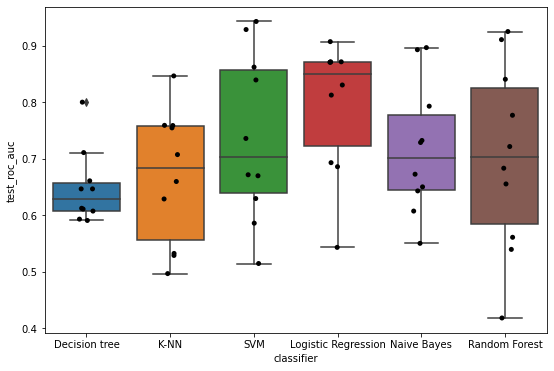

In [105]:
plt.figure(figsize=(9, 6))
sb.boxplot(x="classifier", y="test_roc_auc", data=baseline_df);
sb.stripplot(x='classifier', y='test_roc_auc', data=baseline_df, jitter=True, color='black');

#### Fit and score times

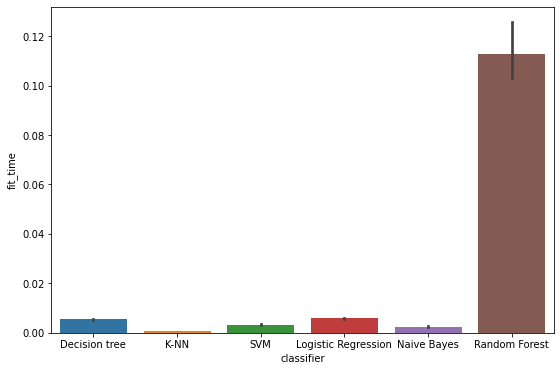

In [106]:
plt.figure(figsize=(9, 6))
sb.barplot(x="classifier", y="fit_time", data=baseline_df);

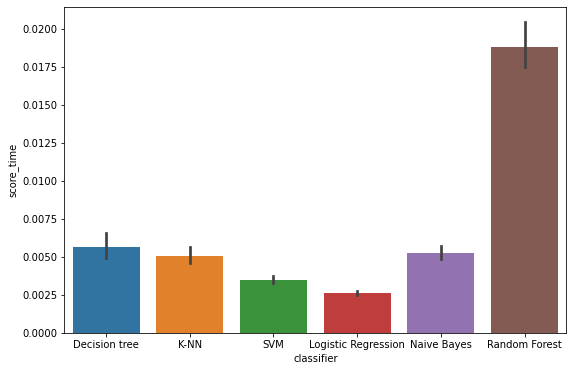

In [107]:
plt.figure(figsize=(9, 6))
sb.barplot(x="classifier", y="score_time", data=baseline_df);

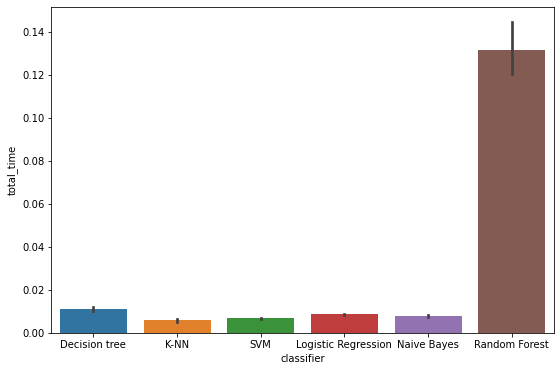

In [108]:
baseline_df["total_time"] = baseline_df["score_time"] + baseline_df["fit_time"]

plt.figure(figsize=(9, 6))
sb.barplot(x="classifier", y="total_time", data=baseline_df);

### Parameter tuning

We will now tune the parameters, so we can find which is the best classifier to use in our problem.

In [109]:
from sklearn.model_selection import GridSearchCV

def grid_search(clf, parameter_grid, scale=False):
    grid_search = GridSearchCV(clf,
                               param_grid=parameter_grid,
                               cv=kf,
                               scoring="roc_auc",
                               n_jobs=configNJobs)
    #Xt = X_train_scaled if scale else X_train 
    Xt = X_train_scaled if scale else X_train
    grid_search.fit(Xt, y_train)
    # output info
    print("Best score: {}".format(grid_search.best_score_))
    print("Best parameters: {}".format(grid_search.best_params_))
    # return the best classifier
    return grid_search.best_estimator_

#### Decision tree classifier

In [110]:
from sklearn.tree import DecisionTreeClassifier

dt_param_grid = {"criterion": ["gini", "entropy"],
                 "splitter": ["best", "random"],
                 "max_depth": [8, 9, 10],
                 "max_features": np.arange(5, 16, 1),
                 "class_weight": [None, "balanced"],
                 "random_state": [0]}

dt_classifier = grid_search(DecisionTreeClassifier(), dt_param_grid)

Best score: 0.7396089901477833
Best parameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 9, 'max_features': 10, 'random_state': 0, 'splitter': 'random'}


#### K-Nearest neighbors classifier

In [111]:
from sklearn.neighbors import KNeighborsClassifier

knn_param_grid = {"algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
                  "n_neighbors": [9, 10, 11, 12, 13],
                  "weights": ["uniform", "distance"],
                  "p": [1, 2]}

knn_classifier = grid_search(KNeighborsClassifier(), knn_param_grid, True)

Best score: 0.7198152709359606
Best parameters: {'algorithm': 'auto', 'n_neighbors': 13, 'p': 2, 'weights': 'distance'}


#### Support vector classifier

In [112]:
from sklearn.svm import SVC

sv_param_grid = {"C": [0.01, 0.1, 1, 10],
                 "gamma": ["auto", "scale"],
                 "kernel": ["linear", "rbf", "sigmoid"],
                 "probability": [True],
                 "random_state": [0]}

sv_classifier = grid_search(SVC(), sv_param_grid, True)

Best score: 0.7981342364532019
Best parameters: {'C': 0.1, 'gamma': 'auto', 'kernel': 'linear', 'probability': True, 'random_state': 0}


#### Logistic regression classifier

In [113]:
from sklearn.linear_model import LogisticRegression

# For small datasets, ‘liblinear’ is a good choice,
# whereas ‘sag’ and ‘saga’ are faster for large ones;
# For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’
# handle multinomial loss;
#‘liblinear’ is limited to one-versus-rest schemes.

lr_param_grid = {
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],
    "random_state": [0],
}

lr_classifier = grid_search(LogisticRegression(), lr_param_grid, True)

Best score: 0.7978879310344826
Best parameters: {'penalty': 'l1', 'random_state': 0, 'solver': 'liblinear'}


#### Naive Bayes

In [114]:
from sklearn.naive_bayes import GaussianNB

nb_param_grid = {"var_smoothing": np.logspace(0, -9, num=100)}
nb_classifier = grid_search(GaussianNB(), nb_param_grid)

Best score: 0.7180726600985222
Best parameters: {'var_smoothing': 2.848035868435799e-07}


#### Random forest classifier

In [115]:
from sklearn.ensemble import RandomForestClassifier

# "max_features": np.arange(5, len(attributes) + 1, 1)
rf_param_grid = {"n_estimators": [10, 20, 50, 75, 100],
                 "criterion": ["gini", "entropy"],
                 "max_depth": [8, 9, 10],
                 "max_features": [4, 5, 6, 7],
                 "random_state": [0]}

rf_classifier = grid_search(RandomForestClassifier(), rf_param_grid)

Best score: 0.78246921182266
Best parameters: {'criterion': 'entropy', 'max_depth': 9, 'max_features': 7, 'n_estimators': 50, 'random_state': 0}


### Oversampling

In [116]:
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE

def grid_search_oversample(clf, parameter_grid, param_prefix, scale=False):
    imba_pipeline = make_pipeline(SMOTE(random_state=0, n_jobs=configNJobs), clf)
    prefixed_param_grid = {}
    for key in parameter_grid:
        prefixed_param_grid[param_prefix + key] = parameter_grid[key]
    return grid_search(imba_pipeline, prefixed_param_grid, scale)

#### Decision tree classifier

In [117]:
dt_classifier_os = grid_search_oversample(DecisionTreeClassifier(), dt_param_grid, "decisiontreeclassifier__")

Best score: 0.7965209359605911
Best parameters: {'decisiontreeclassifier__class_weight': None, 'decisiontreeclassifier__criterion': 'entropy', 'decisiontreeclassifier__max_depth': 8, 'decisiontreeclassifier__max_features': 8, 'decisiontreeclassifier__random_state': 0, 'decisiontreeclassifier__splitter': 'best'}


#### K-Nearest neighbors classifier

In [118]:
knn_classifier_os = grid_search_oversample(KNeighborsClassifier(), knn_param_grid, "kneighborsclassifier__", True)

Best score: 0.7017056650246306
Best parameters: {'kneighborsclassifier__algorithm': 'auto', 'kneighborsclassifier__n_neighbors': 9, 'kneighborsclassifier__p': 2, 'kneighborsclassifier__weights': 'distance'}


#### Support vector classifier

In [119]:
sv_classifier_os = grid_search_oversample(SVC(), sv_param_grid, "svc__", True)

Best score: 0.7904064039408867
Best parameters: {'svc__C': 0.1, 'svc__gamma': 'auto', 'svc__kernel': 'linear', 'svc__probability': True, 'svc__random_state': 0}


#### Naive Bayes classifier

In [120]:
nb_classifier_os = grid_search_oversample(GaussianNB(), nb_param_grid, "gaussiannb__")

Best score: 0.7184852216748767
Best parameters: {'gaussiannb__var_smoothing': 1.873817422860383e-07}


#### Logistic Regression classifier

In [121]:
lr_classifier_os = grid_search_oversample(LogisticRegression(), lr_param_grid, "logisticregression__", True)

Best score: 0.7810406403940886
Best parameters: {'logisticregression__penalty': 'l2', 'logisticregression__random_state': 0, 'logisticregression__solver': 'liblinear'}


#### Random forest classifier

In [122]:
rf_classifier_os = grid_search_oversample(RandomForestClassifier(), rf_param_grid, "randomforestclassifier__")

Best score: 0.7965825123152709
Best parameters: {'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 10, 'randomforestclassifier__max_features': 4, 'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__random_state': 0}


### Compare results

In [123]:
clfs = {
    "Decision tree": {"clf": dt_classifier, "clf_os": dt_classifier_os, "scale": False},
    "K-NN": {"clf": knn_classifier, "clf_os": knn_classifier_os, "scale": True},
    "SVM": {"clf": sv_classifier, "clf_os": sv_classifier_os, "scale": True},
    "Logistic regression": {"clf": lr_classifier, "clf_os": lr_classifier_os, "scale": True},
    "Naive Bayes": {"clf": nb_classifier, "clf_os": nb_classifier_os, "scale": False},
    "Random forest": {"clf": rf_classifier, "clf_os": rf_classifier_os, "scale": False},
}

In [124]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def get_clf_metrics(name):
    clf_pair = clfs[name]
    scores = {"accuracy": [], "precision": [], "recall": [], "f1": [], "auc": [], "oversampled": ["no", "yes"], "classifier": [name] * 2}
    Xt = X_train_scaled if clf_pair["scale"] else X_train

    for clf in [clf_pair["clf"], clf_pair["clf_os"]]:
        y_pred = clf.predict(Xt)
        scores["accuracy"].append(accuracy_score(y_train, y_pred))
        scores["precision"].append(precision_score(y_train, y_pred))
        scores["recall"].append(recall_score(y_train, y_pred))
        scores["f1"].append(f1_score(y_train, y_pred))
        # roc curve stuff
        scores["auc"].append(roc_auc_score(y_train, clf.predict_proba(Xt)[:, 1]))
    
    return pd.DataFrame(scores)

In [125]:
clfs_pd = pd.DataFrame()

for name in clfs:
    clfs_pd = clfs_pd.append(get_clf_metrics(name))

clfs_pd

,accuracy,precision,recall,f1,auc,oversampled,classifier
0,0.740854,0.966825,0.723404,0.827586,0.879934,no,Decision tree
1,0.884146,0.969231,0.893617,0.929889,0.946924,yes,Decision tree
0,1.000000,1.000000,1.000000,1.000000,1.000000,no,K-NN
1,1.000000,1.000000,1.000000,1.000000,1.000000,yes,K-NN
0,0.896341,0.897436,0.992908,0.942761,0.859929,no,SVM
1,0.789634,0.973333,0.776596,0.863905,0.888259,yes,SVM
0,0.899390,0.905537,0.985816,0.943973,0.898319,no,Logistic regression
1,0.804878,0.973913,0.794326,0.875000,0.906876,yes,Logistic regression
0,0.878049,0.895425,0.971631,0.931973,0.746608,no,Naive Bayes
1,0.679878,0.931707,0.677305,0.784394,0.761486,yes,Naive Bayes


### Output test results

In [126]:
def output_pred(name, os=False, pred_class=1):
    clf_pair = clfs[name]
    Xt = X_test_scaled if clf_pair["scale"] else X_test
    
    # not oversampled scoring
    clf = clf_pair["clf_os"] if os else clf_pair["clf"]
    y_pred_prob = clf.predict_proba(Xt)
    ind = np.where(clf.classes_ == pred_class)[0][0]
    y_pred = y_pred_prob[:, ind]
    
    ret = y_test.copy().reset_index()
    ret["status"] = y_pred
    ret["id"] = loan_test_df["loan_id"]
    ret.drop(["index"], axis=1, inplace=True)
    ret.rename(columns={"status": "predicted"}, inplace=True)
    ret = ret[ret.columns[::-1]]
    return ret

In [127]:
from pathlib import Path

filepath = Path('output')
filepath.parent.mkdir(parents=True, exist_ok=True)

#### Decision tree classifier

In [128]:
dt_pd = output_pred("Decision tree")
dt_pd.to_csv('output/decision_tree.csv', index=False)
dt_os_pd = output_pred("Decision tree", os=True)
dt_os_pd.to_csv('output/decision_tree_os.csv', index=False)

#### K-Nearest neighbors classifier

In [129]:
knn_pd = output_pred("K-NN")
knn_pd.to_csv('output/knn.csv', index=False)
knn_os_pd = output_pred("K-NN", os=True)
knn_os_pd.to_csv('output/knn_os.csv', index=False)

#### SVM classifier

In [130]:
sv_pd = output_pred("SVM")
sv_pd.to_csv('output/sv.csv', index=False)
sv_os_pd = output_pred("SVM", os=True)
sv_os_pd.to_csv('output/sv_os.csv', index=False)

#### Logistic Regression classifier

In [131]:
lr_pd = output_pred("Logistic regression")
lr_pd.to_csv('output/logistic_regression.csv', index=False)
lr_os_pd = output_pred("Logistic regression")
lr_os_pd.to_csv('output/logistic_regression_os.csv', index=False)

#### Naive Bayes classifier

In [132]:
nb_pd = output_pred("Naive Bayes")
nb_pd.to_csv('output/naive_bayes.csv', index=False)
nb_os_pd = output_pred("Naive Bayes")
nb_os_pd.to_csv('output/naive_bayes_os.csv', index=False)

#### Random forest classifier

In [133]:
rf_pd = output_pred("Random forest")
rf_pd.to_csv('output/random_forest.csv', index=False)
rf_os_pd = output_pred("Random forest")
rf_os_pd.to_csv('output/random_forest_os.csv', index=False)

## Credits

**Authors**:

- Ana Inês Oliveira de Barros, up201806593@edu.fe.up.pt
- João de Jesus Costa, up201806560@edu.fe.up.pt
- João Lucas Silva Martins, up201806436@edu.fe.up.pt

**Development environment**: Jupyter 4.6.3-2

**Python implementation**: CPython 3.9.4

**Python modules**:

- matplotlib 3.4.1-2
- numpy 1.20.2-1
- pandas 1.2.3-1
- scikit-learn 0.24.1-1
- imblearn 0.7.0-1
- scipy 1.6.3-1
- seaborn 0.11.1-1

IART MIEIC, FEUP - May, 2021